# TODO: 
- Tutte le task: fare train con 30 seeds (?) e 20 epoche (?) e poi fare commenti risultati
- ~~Tutte le task: gestire val loss?~~
- ~~Tutte le task: impostare salvataggio dei risultati (array numpy -> pd DataFrame -> file excel) e grafici ~~
- ~~Task 3: rapporti alpha e beta per mixed da capire anche in base al punto precedente -> facciamo 1 e 1~~
- Task 4: gamma partire con 1.0 ma eventualmente da fare un po' di esperimenti / tuning 
- Task 4: fare solo con dati migliori (alpha e beta di conseguenza)
- Task 4: provare a implementare anche strada con log e exp anzichè aggiungere nuova loss 
- Task 5: aggiungere lagrangiano a modello migliore 
- Task 5: peso dinamico a beta (eventualmente gamma se usiamo modello task 4), alpha statico a 1
- Task 5: fare solo con dati migliori

- PW da impostare dopo aver discusso progetto

In [152]:
!pip install tabulate

In [469]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from tabulate import tabulate
import random

from util import cst

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras import backend as k
from keras.callbacks import CSVLogger

#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error

# Parameters
stop = 1400
epochs = 5
batch_size = 32
num_seeds = 2
excel_file_path = 'results.xlsx'



## Data Loading and Preparation

### Data loading

In [154]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection


- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [155]:
data.head()

src  machine  cycle      p1      p2     p3      s1      s2  \
0  train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1  train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2  train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3  train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4  train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   

        s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0  1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  rul  
0  39.06  23.4190  191  
1  39.00  23.4236  190  
2  38.95  23.3442  189  
3  38.88  23.3739  188  
4  38.90  23.4044  187  

[5 rows x 28 columns]

Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [156]:
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

src  machine  cycle      p1      p2     p3      s1      s2  \
0    train_FD001        1      1 -0.0007 -0.0004  100.0  518.67  641.82   
1    train_FD001        1      2  0.0019 -0.0003  100.0  518.67  642.15   
2    train_FD001        1      3 -0.0043  0.0003  100.0  518.67  642.35   
3    train_FD001        1      4  0.0007  0.0000  100.0  518.67  642.35   
4    train_FD001        1      5 -0.0019 -0.0002  100.0  518.67  642.37   
..           ...      ...    ...     ...     ...    ...     ...     ...   
187  train_FD001        1    188 -0.0067  0.0003  100.0  518.67  643.75   
188  train_FD001        1    189 -0.0006  0.0002  100.0  518.67  644.18   
189  train_FD001        1    190 -0.0027  0.0001  100.0  518.67  643.64   
190  train_FD001        1    191 -0.0000 -0.0004  100.0  518.67  643.34   
191  train_FD001        1    192  0.0009 -0.0000  100.0  518.67  643.54   

          s3       s4  ...      s13      s14     s15   s16  s17   s18    s19  \
0    1589.70  1400.60  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1    1591.82  1403.14  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2    1587.99  1404.20  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3    1582.79  1401.87  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4    1582.85  1406.22  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0   
..       ...      ...  ...      ...      ...     ...   ...  ...   ...    ...   
187  1602.38  1422.78  ...  2388.23  8117.69  8.5207  0.03  396  2388  100.0   
188  1596.17  1428.01  ...  2388.33  8117.51  8.5183  0.03  395  2388  100.0   
189  1599.22  1425.95  ...  2388.35  8112.58  8.5223  0.03  398  2388  100.0   
190  1602.36  1425.77  ...  2388.30  8114.61  8.5174  0.03  394  2388  100.0   
191  1601.41  1427.20  ...  2388.32  8110.93  8.5113  0.03  396  2388  100.0   

       s20      s21  rul  
0    39.06  23.4190  191  
1    39.00  23.4236  190  
2    38.95  23.3442  189  
3    38.88  23.3739  188  
4    38.90  23.4044  187  
..     ...      ...  ...  
187  38.51  22.9588    4  
188  38.48  23.1127    3  
189  38.49  23.0675    2  
190  38.45  23.1295    1  
191  38.48  22.9649    0  

[192 rows x 28 columns]

We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

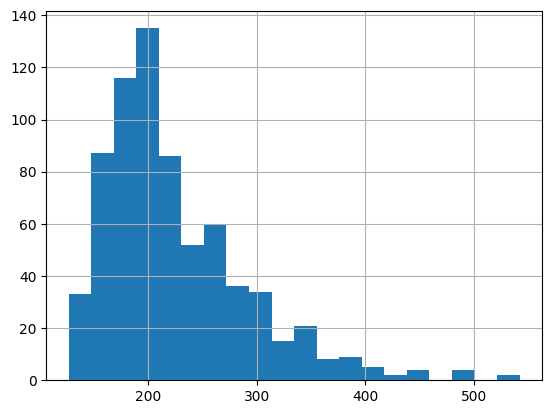

In [157]:
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)

In [158]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [159]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

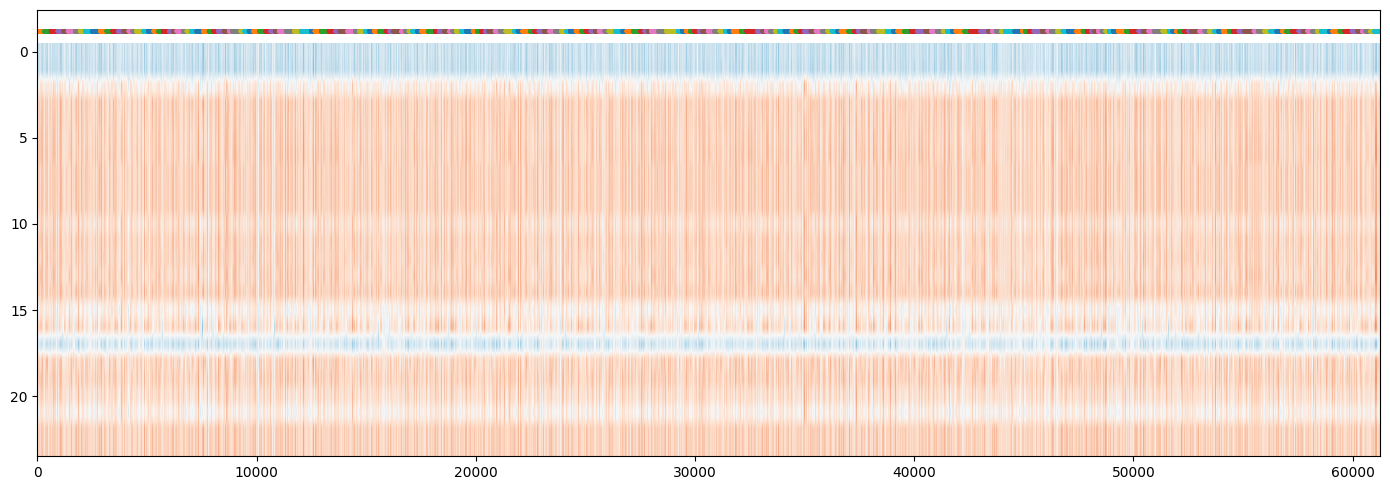

In [160]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

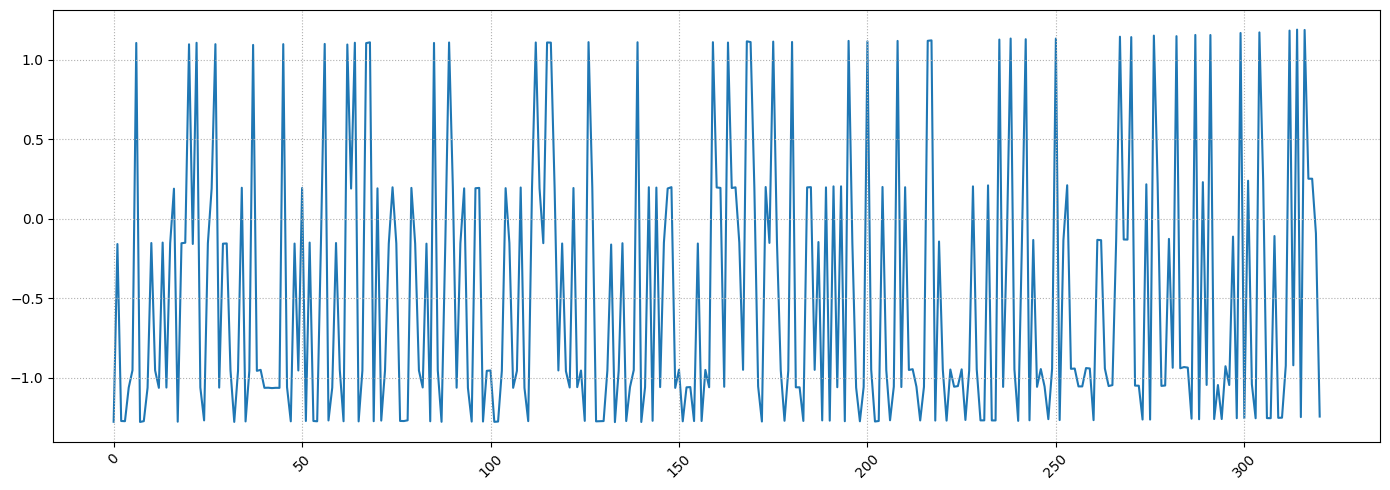

In [161]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [162]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [163]:
dt.head()

src  machine  cycle        p1        p2        p3        s1  \
0  train_FD004      461      1  1.500057  1.168664  0.345954 -1.342550   
1  train_FD004      461      2  0.168806  0.788709  0.345954  0.175840   
2  train_FD004      461      3  1.499991  1.171110  0.345954 -1.342550   
3  train_FD004      461      4  1.499761  1.168664  0.345954 -1.342550   
4  train_FD004      461      5  0.471584  0.572641 -2.890543 -0.765963   

         s2        s3        s4  ...       s13       s14       s15       s16  \
0 -1.122474 -1.045952 -1.086033  ...  0.344929 -0.175148  0.370889 -1.037783   
1  0.205021  0.089480 -0.172094  ...  0.342590 -0.531124  0.181688 -1.037783   
2 -1.139659 -1.048575 -1.055806  ...  0.344749 -0.276979  0.460301 -1.037783   
3 -1.145544 -1.064484 -1.048616  ...  0.345198 -0.160016  0.375413 -1.037783   
4 -1.442165 -1.792301 -1.668131  ... -2.892626 -2.767824  2.370806 -1.037783   

        s17       s18       s19       s20       s21  rul  
0 -0.989600 -0.433322  0.345954 -1.310594 -1.311278  320  
1  0.009709  0.352571  0.345954 -0.134518 -0.129792  319  
2 -1.021836 -0.433322  0.345954 -1.322569 -1.303537  318  
3 -1.054071 -0.433322  0.345954 -1.317437 -1.304065  317  
4 -1.795494 -2.517341 -2.890543 -1.018927 -0.982214  316  

[5 rows x 28 columns]

## **Project**

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

For the first 3 tasks we use the following training configuration, where we will change parameters according to the task addressed.

In [470]:
def train_model(train_data, val_data, test_data, columns, maxrul, alpha, beta, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstRULRegressor(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred

The following function is used to train the model for task 4.

In [490]:
def train_task4(train_data, val_data, test_data, columns, maxrul, alpha, beta, gamma, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstPosRULRegressor(len(columns), alpha=alpha, beta=beta, gamma=gamma, maxrul=maxrul, hidden=[32, 32])
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred
    

Function *train_task5* is used to train the last task of our project.

In [491]:
def train_task5(train_data, val_data, test_data, columns, maxrul, alpha, beta, logger_file, seeds=num_seeds, epochs=epochs):
    pred = []
    history = []
    if os.path.exists('./history/'+logger_file):
        os.remove('./history/'+logger_file)
    for i in range(seeds):
        np.random.seed(i)
        tf.random.set_seed(i)
        random.seed(i)
        nn = cst.CstRULRegressorWithLagrangian(input_shape=len(columns), alpha=alpha, beta=beta, maxrul=maxrul, hidden=[32, 32]) 
        batch_gen = cst.CstBatchGenerator(train_data, columns, batch_size=32, seed=i)
        batch_gen_val = cst.CstBatchGenerator(val_data, columns, batch_size=32, seed=i)
        cb = callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        csv_logger = CSVLogger('./history/'+logger_file, separator=',', append=True)
        nn.compile(optimizer='Adam', run_eagerly=False)
        history.append(nn.fit(batch_gen, validation_data=batch_gen_val, epochs=epochs, verbose=1, callbacks=[cb, csv_logger]))
        pred.append(np.round(nn.predict(test_data[columns]).ravel()*maxrul))
    return history, pred

### **Task 1**: train the model with only supervised data. We will experiment with different ratios of supervised data. 


In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better. 
- Moreover, we expect that they learn the decreasing trend and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances won't be as significant as those in the models with both supervised and unsupervised data. 

#### 1.1 100% of supervised data used for training

In [466]:
trs, vs, ts = cst.split_machines(dt, 0.75, 0)

Num. machines: 149 (supervised), 37 (validation), 63 (test)


In [467]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs, vs, ts, dt_in)

We train the model with different seeds

In [472]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-1.log')

Epoch 1/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0214 - mse: 0.0214 - cst: 0.0075 - val_loss: 0.0170 - val_mse: 0.0170 - val_cst: 0.0042
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0149 - mse: 0.0149 - cst: 0.0041 - val_loss: 0.0174 - val_mse: 0.0174 - val_cst: 0.0035
Epoch 3/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0040 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0054
Epoch 4/5
1232/1232 [==============================] - 5s 4ms/step - loss: 0.0144 - mse: 0.0144 - cst: 0.0037 - val_loss: 0.0156 - val_mse: 0.0156 - val_cst: 0.0045
Epoch 5/5
496/496 [==============================] - 0s 515us/step
Epoch 1/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0217 - mse: 0.0217 - cst: 0.0060 - val_loss: 0.0155 - val_mse: 0.0155 - val_cst: 0.0028
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0172 - mse: 0.0172 - cst: 0.004

Train history visualization for the first seed

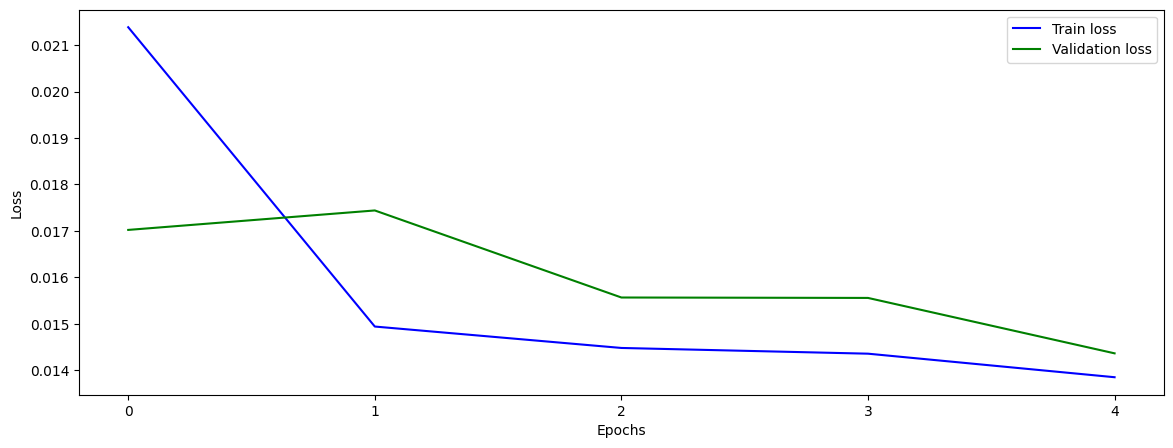

In [223]:
history = pd.read_csv('history/training-1-1.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

Evaluation on the test set

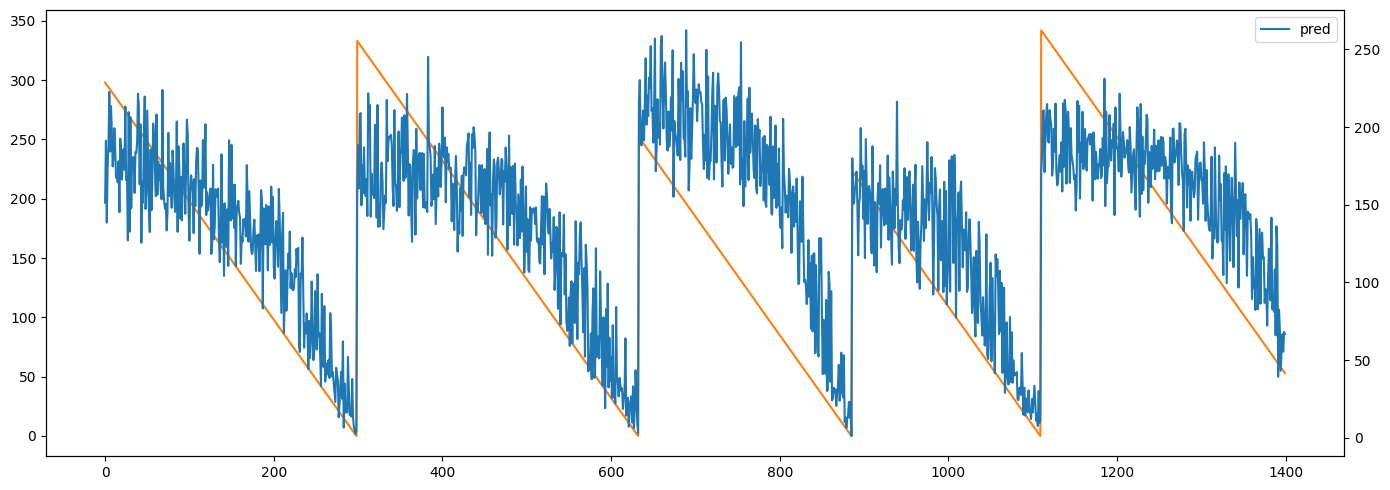

In [224]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [225]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0129
Standard Deviation of MSE: 0.0004


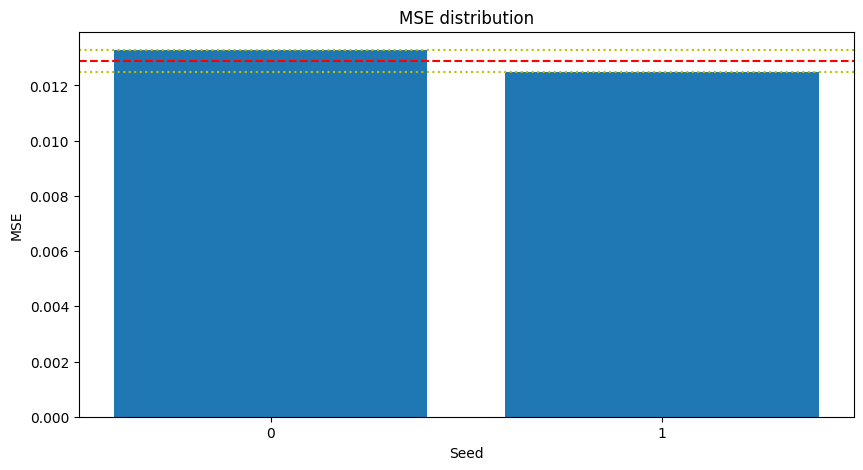

In [226]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [227]:
cst.save_results_to_excel("Task 1.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [231]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-1.xlsx')

In [232]:
pd.read_excel('./predictions/predictions-1-1.xlsx').head(10)

Seed_0      Seed_1  rul
0  151.411194  174.130142  298
1  191.288834  200.025085  297
2  138.489807  166.466583  296
3  174.445343  203.896469  295
4  187.965225  198.307907  294
5  222.636551  217.437576  293
6  184.302094  177.034012  292
7  213.526932  179.867188  291
8  197.002838  176.416641  290
9  174.694763  165.186630  289

#### 1.2 75% of supervised data used for training

In [81]:
trs_2 = cst.split_data(ts, trs=trs, trs_ratio=0.75)

Num. samples: 27559 (supervised), 15864 (test)


In [82]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_2, vs, ts, dt_in)

In [83]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-2.log')

Epoch 1/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0230 - mse: 0.0230 - cst: 0.0086 - val_loss: 0.0149 - val_mse: 0.0149 - val_cst: 0.0041
Epoch 2/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0165 - mse: 0.0165 - cst: 0.0045 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 3/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0160 - mse: 0.0160 - cst: 0.0041 - val_loss: 0.0157 - val_mse: 0.0157 - val_cst: 0.0066
Epoch 4/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0041 - val_loss: 0.0142 - val_mse: 0.0142 - val_cst: 0.0022
Epoch 5/5
496/496 [==============================] - 0s 390us/step
Epoch 1/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0236 - mse: 0.0236 - cst: 0.0070 - val_loss: 0.0171 - val_mse: 0.0171 - val_cst: 0.0027
Epoch 2/5
921/921 [==============================] - 3s 3ms/step - loss: 0.0183 - mse: 0.0183 - cst: 0.0044 - val_loss

Train history visualization for the first seed

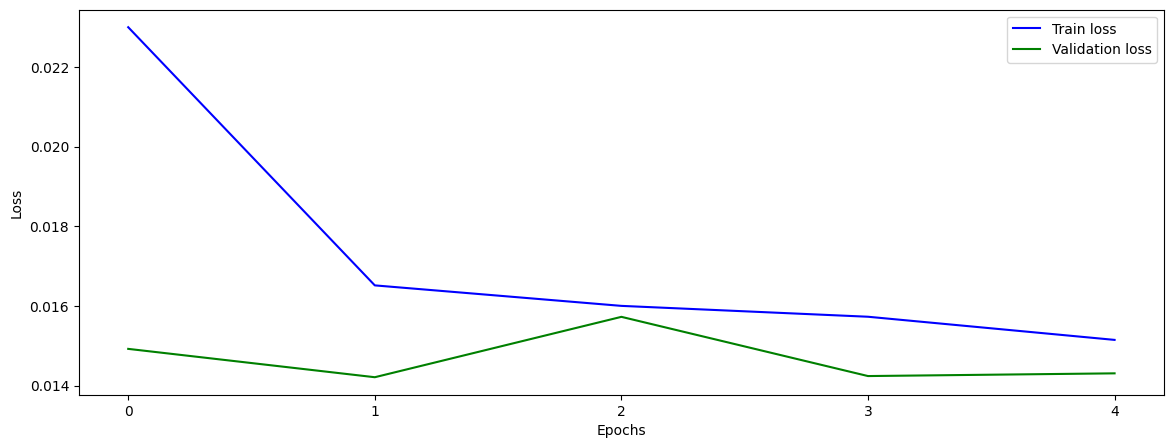

In [195]:
history = pd.read_csv('history/training-1-2.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

Evaluation on the test set 

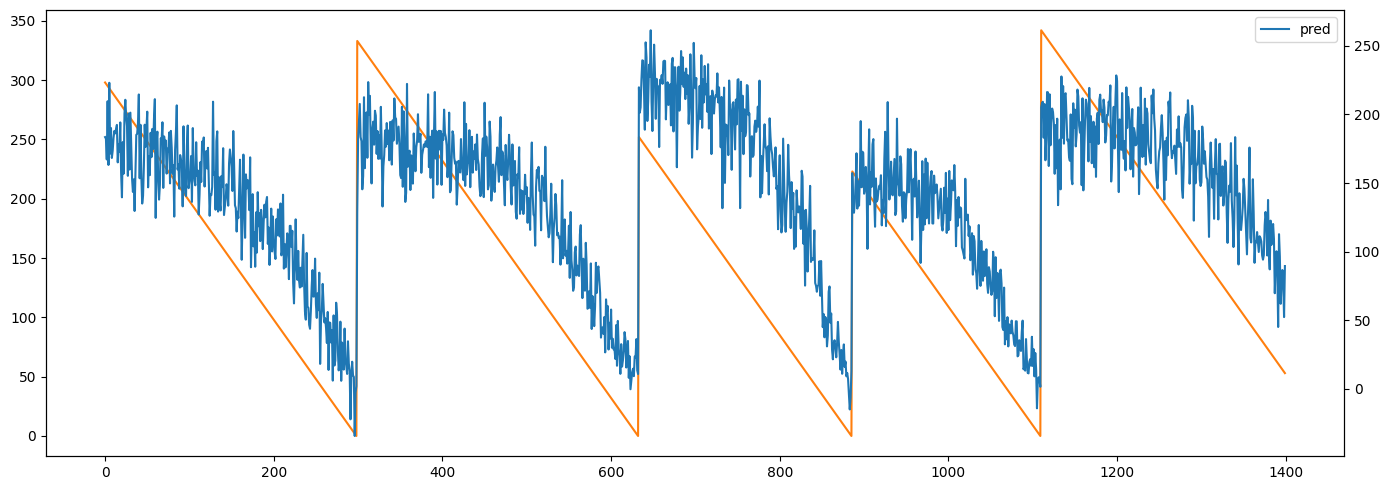

In [86]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [87]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0132
Standard Deviation of MSE: 0.0003


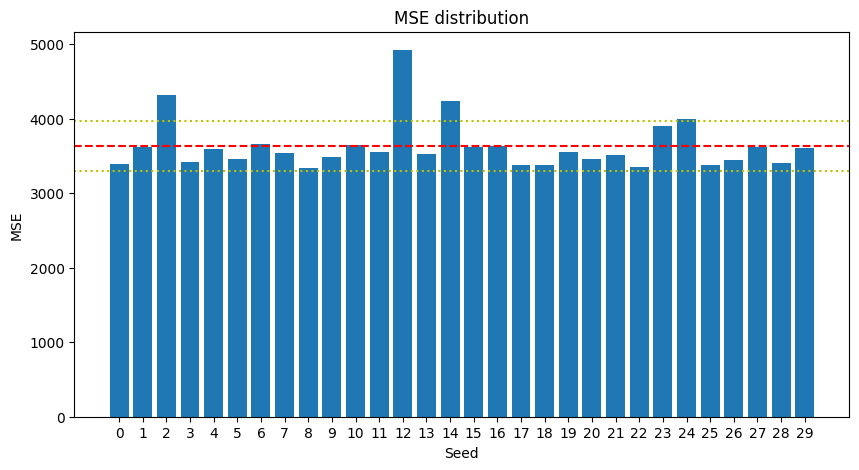

In [367]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [33]:
cst.save_results_to_excel("Task 1.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [30]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-2.xlsx')

In [31]:
pd.read_excel('./predictions/predictions-1-2.xlsx').head(10)

Seed_0      Seed_1  rul
0  211.759918  206.417938  298
1  189.309464  202.731842  297
2  189.211624  193.479462  296
3  226.520065  226.151413  295
4  197.447006  257.995422  294
5  222.880829  214.664459  293
6  183.047821  178.316345  292
7  217.585800  211.452194  291
8  201.721436  212.158737  290
9  176.886551  192.023575  289

#### 1.3 50% of supervised data used for training

In [197]:
trs_3 = cst.split_data(ts, trs=trs, trs_ratio=0.50)

Num. samples: 18373 (supervised), 15864 (test)


In [198]:
trs_s, vs_s, ts_s, trmaxrul = cst.standardize(trs_3, vs, ts, dt_in)

In [199]:
history, predictions = train_model(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-1-3.log')

Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0243 - mse: 0.0243 - cst: 0.0106 - val_loss: 0.0184 - val_mse: 0.0184 - val_cst: 0.0036
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0157 - mse: 0.0157 - cst: 0.0044 - val_loss: 0.0198 - val_mse: 0.0198 - val_cst: 0.0035
Epoch 3/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0156 - mse: 0.0156 - cst: 0.0043 - val_loss: 0.0159 - val_mse: 0.0159 - val_cst: 0.0025
Epoch 4/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0038 - val_loss: 0.0138 - val_mse: 0.0138 - val_cst: 0.0034
Epoch 5/5
496/496 [==============================] - 0s 386us/step
Epoch 1/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0234 - mse: 0.0234 - cst: 0.0068 - val_loss: 0.0181 - val_mse: 0.0181 - val_cst: 0.0049
Epoch 2/5
615/615 [==============================] - 2s 3ms/step - loss: 0.0183 - mse: 0.0183 - cst: 0.0052 - val_loss

Train history visualization for the first seed

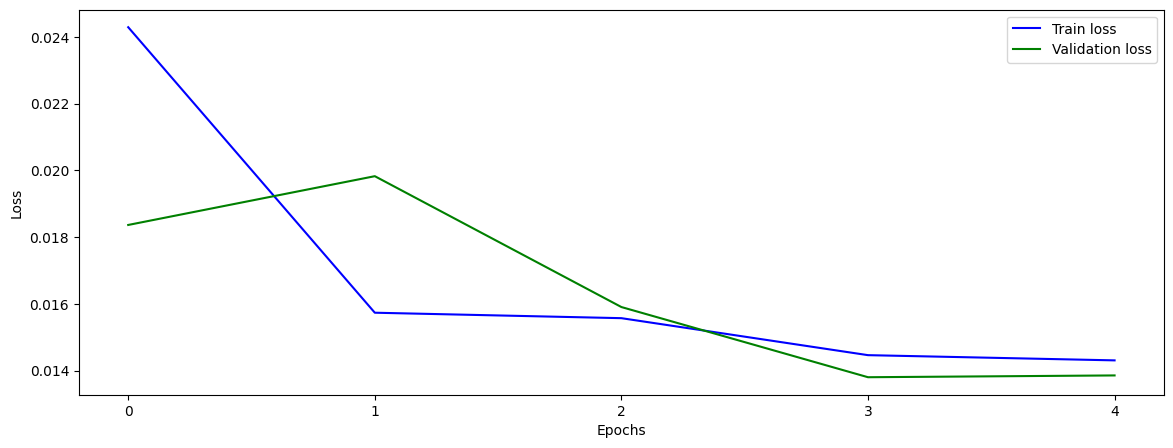

In [196]:
history = pd.read_csv('history/training-1-3.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

Evaluation on the test set

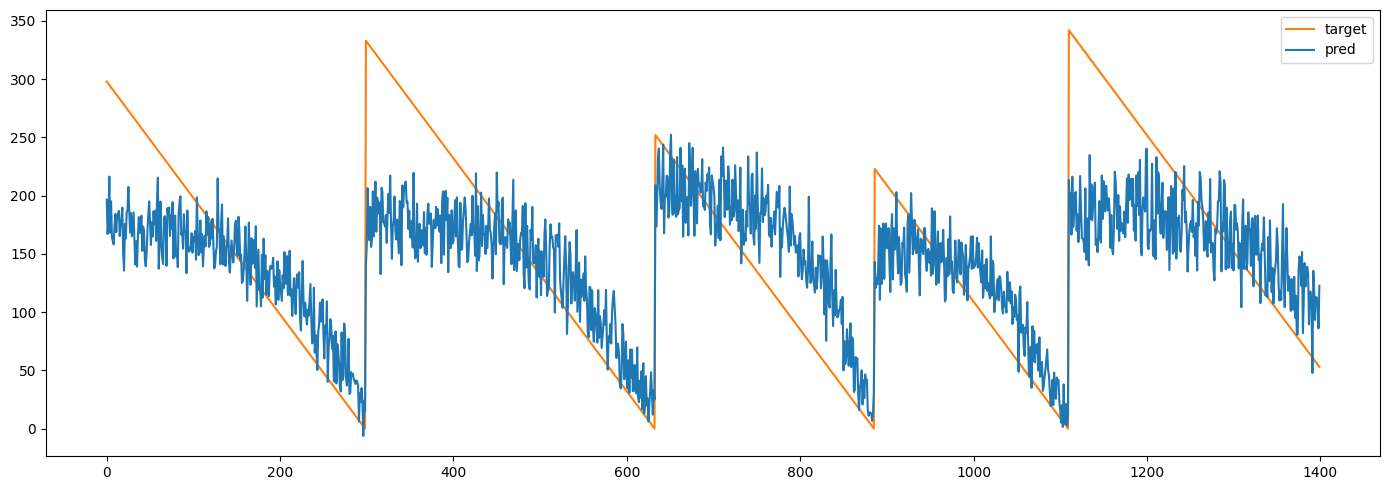

In [200]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [201]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0143
Standard Deviation of MSE: 0.0007


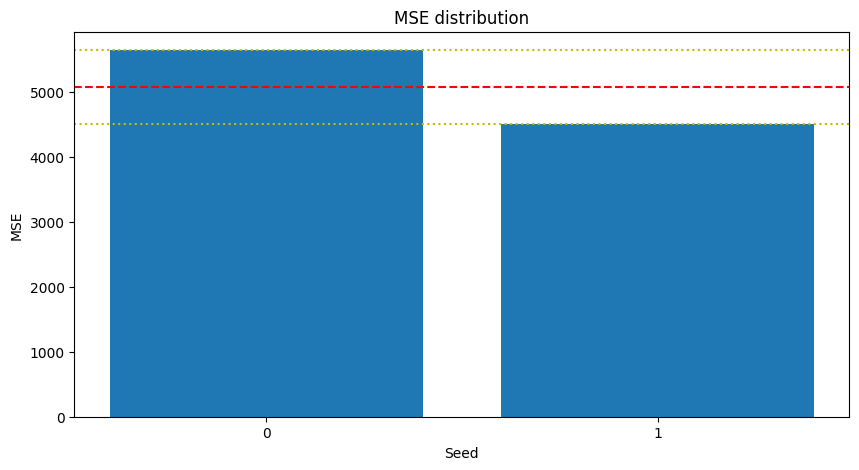

In [43]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [44]:
cst.save_results_to_excel("Task 1.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [46]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-1-3.xlsx')

In [47]:
pd.read_excel('./predictions/predictions-1-3.xlsx').head(10)

Seed_0      Seed_1  rul
0  152.105408  191.217407  298
1  208.146179  196.382126  297
2  136.038956  181.963287  296
3  172.587631  210.188400  295
4   90.048561  181.572968  294
5  233.642746  204.206985  293
6  194.759460  171.159088  292
7  220.900040  183.582336  291
8  197.330170  182.625275  290
9  191.844040  173.469208  289

#### Results on Task 1


In [202]:
results_task1 = pd.read_excel('results.xlsx')

results_task1_1= results_task1[results_task1['Task'] == 'Task 1.1']
results_task1_2 = results_task1[results_task1['Task'] == 'Task 1.2']
results_task1_3 = results_task1[results_task1['Task'] == 'Task 1.3']

drop_columns = [col for col in results_task1_1.columns if 'Seed_' in col]

res_task1 = pd.concat([results_task1_1, results_task1_2, results_task1_3]).drop(columns=drop_columns)

print(tabulate(res_task1, headers='keys', showindex= False, tablefmt='psql'))

+----------+--------------+---------------+
| Task     |         Mean |           Std |
|----------+--------------+---------------|
| Task 1.1 |    0.0128889 |   0.000392717 |
| Task 1.2 | 4449.2       | 388.466       |
| Task 1.3 | 5079.34      | 571.356       |
+----------+--------------+---------------+


Task 1 uses only supervised data, as we expected (..) the best model is the one that uses 100% of the data, but the other two don't have such worse performances. 
The mean of the *mse* metric is quite low, mainly because it is computed on standardized data. Indeed, if we observe closer the prediction  (non standardize) we observe that there is a quite great gap between the real rul value and the predicted one. 

In [193]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-1-1.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=['Seed 1', 'Seed 2', 'RUL'],  tablefmt='psql'))

+-----------+-----------+-------+
|    Seed 1 |    Seed 2 |   RUL |
|-----------+-----------+-------|
| 151.411   | 174.13    |   298 |
| 191.289   | 200.025   |   297 |
| 138.49    | 166.467   |   296 |
| 174.445   | 203.896   |   295 |
| 187.965   | 198.308   |   294 |
| 222.637   | 217.438   |   293 |
| 184.302   | 177.034   |   292 |
| 213.527   | 179.867   |   291 |
| 197.003   | 176.417   |   290 |
| 174.695   | 165.187   |   289 |
| 180.794   | 177.23    |   288 |
| 199.321   | 192.746   |   287 |
| 185.833   | 187.861   |   286 |
| 167.471   | 194.574   |   285 |
| 169.804   | 192.59    |   284 |
| 164.427   | 159.616   |   283 |
| 178.122   | 187.73    |   282 |
| 145.284   | 167.236   |   281 |
| 192.533   | 183.657   |   280 |
| 184.173   | 173.052   |   279 |
| 166.26    | 158.763   |   278 |
| 179.786   | 176.395   |   277 |
| 185.977   | 198.989   |   276 |
| 172.503   | 199.042   |   275 |
| 213.235   | 216.66    |   274 |
| 165.925   | 188.847   |   273 |
| 168.518   | 

We just printed the predictions for the first machine in the test set. the model is able to guess an inital *rul* closer (but still not perfefct) to the starting *rul* value, and in the end the last values of the *rul* are low and in general quite close to 0. Moreover, we can observe that the model understand well the decreasing trend that a *rul* must follow.
To conclude, the overall results are a rough approximation of the behavior expected, they are not perfect but the initial and  final values are close to the right ones and the trend they follow too.

Aggiungere: all'inizio sbaglia molto, verso la fine è molto più vicino ai valori corretti di rul

### **Task 2**: train the model with only unsupervised data. We will experiment with different ratios of supervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the RUL. However, we will see if it is possible for the regressor to learn the constraint which imposes that the RUL for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial RUL as accurately as the supervised models.
In general, we expect that the perormances will be worse with respect the superivised experiments.

In [203]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)


In [204]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


#### 100% of unsupervised data

In [205]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)

Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [206]:
tru_st = cst.remove_rul(tru_s)

In [207]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-1.log')


Epoch 1/5
1079/1079 [==============================] - 4s 3ms/step - loss: 0.0048 - mse: 0.0000e+00 - cst: 0.0048 - val_loss: 5.8424e-04 - val_mse: 0.0283 - val_cst: 5.8424e-04
Epoch 2/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6191e-04 - mse: 0.0000e+00 - cst: 4.6191e-04 - val_loss: 4.3882e-04 - val_mse: 0.0332 - val_cst: 4.3882e-04
Epoch 3/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.4966e-04 - mse: 0.0000e+00 - cst: 4.4966e-04 - val_loss: 4.2281e-04 - val_mse: 0.0378 - val_cst: 4.2281e-04
Epoch 4/5
1079/1079 [==============================] - 3s 3ms/step - loss: 4.6085e-04 - mse: 0.0000e+00 - cst: 4.6085e-04 - val_loss: 4.0145e-04 - val_mse: 0.0411 - val_cst: 4.0145e-04
Epoch 5/5
496/496 [==============================] - 0s 408us/step
Epoch 1/5
1079/1079 [==============================] - 4s 3ms/step - loss: 0.0021 - mse: 0.0000e+00 - cst: 0.0021 - val_loss: 5.7979e-04 - val_mse: 0.0467 - val_cst: 5.7979e-04
Epoch 2/5
1079/1079 [===

Train history visualization for the first seed

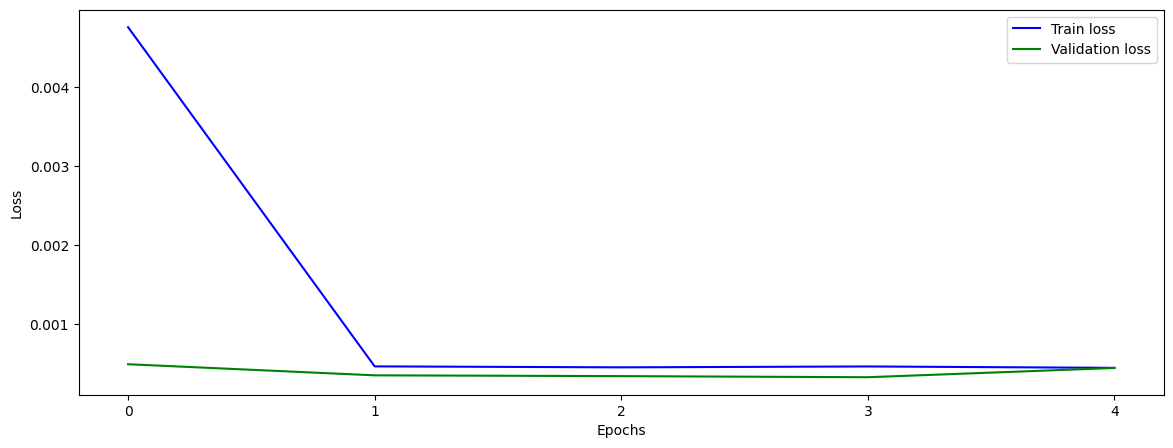

In [209]:
history = pd.read_csv('history/training-2-1.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

Evaluation on the test set

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

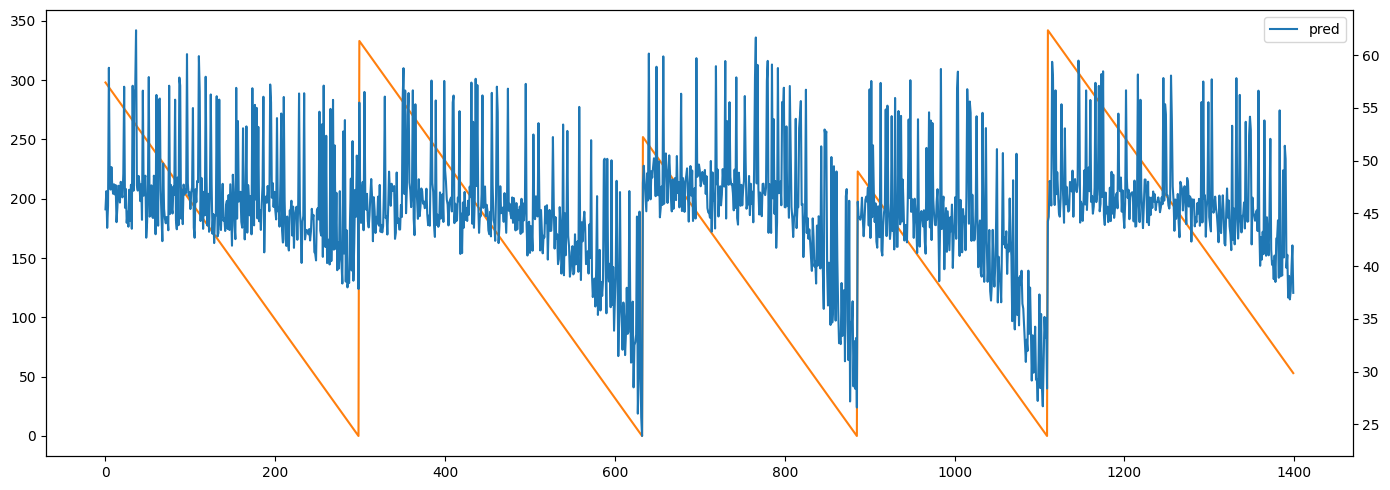

In [210]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [212]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0700
Standard Deviation of MSE: 0.0153


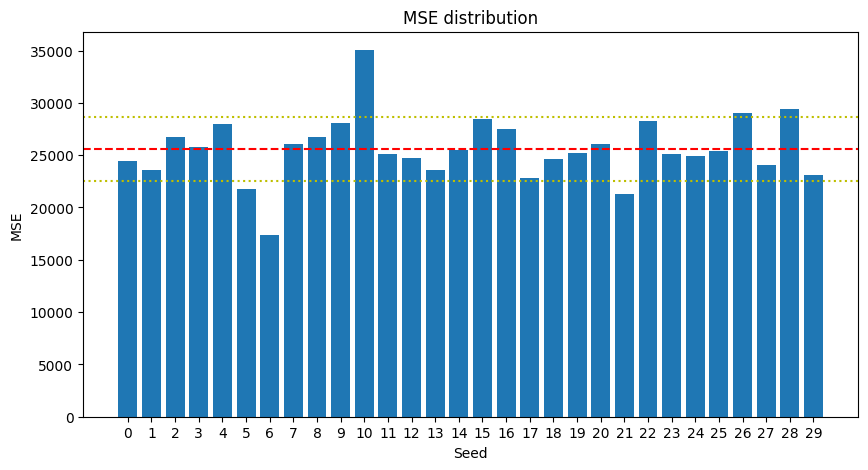

In [382]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [55]:
cst.save_results_to_excel("Task 2.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [57]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-1.xlsx')

In [58]:
pd.read_excel('./predictions/predictions-2-1.xlsx').head(10)

Seed_0     Seed_1  rul
0  76.173302  13.961440  298
1  70.402443  15.141240  297
2  71.187805  13.900810  296
3  75.566689  13.785439  295
4  73.996017   7.561786  294
5  72.044754  14.722753  293
6  71.235741   8.630589  292
7  72.892097   8.290474  291
8  70.499504   7.455242  290
9  71.110764   6.772154  289

#### 75% of unsupervised data

In [101]:
tru_2 = cst.split_data(ts, tru=tru, tru_ratio=0.75)

Num. samples: 27559 (unsupervised), 15864 (test)


In [102]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_2, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [104]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-2.log')

Epoch 1/5
812/812 [==============================] - 2s 3ms/step - loss: 0.0047 - mse: 0.0000e+00 - cst: 0.0047 - val_loss: 4.7982e-04 - val_mse: 0.0000e+00 - val_cst: 4.7982e-04
Epoch 2/5
812/812 [==============================] - 2s 3ms/step - loss: 5.4668e-04 - mse: 0.0000e+00 - cst: 5.4668e-04 - val_loss: 4.4839e-04 - val_mse: 0.0000e+00 - val_cst: 4.4839e-04
Epoch 3/5
812/812 [==============================] - 2s 3ms/step - loss: 5.0930e-04 - mse: 0.0000e+00 - cst: 5.0930e-04 - val_loss: 4.3809e-04 - val_mse: 0.0000e+00 - val_cst: 4.3809e-04
Epoch 4/5
812/812 [==============================] - 3s 3ms/step - loss: 4.7721e-04 - mse: 0.0000e+00 - cst: 4.7721e-04 - val_loss: 0.0017 - val_mse: 0.0000e+00 - val_cst: 0.0017
Epoch 5/5
496/496 [==============================] - 0s 385us/step
Epoch 1/5
812/812 [==============================] - 2s 3ms/step - loss: 0.0025 - mse: 0.0000e+00 - cst: 0.0025 - val_loss: 6.1766e-04 - val_mse: 0.0000e+00 - val_cst: 6.1766e-04
Epoch 2/5
812/812 [===

Train history visualization for the first seed

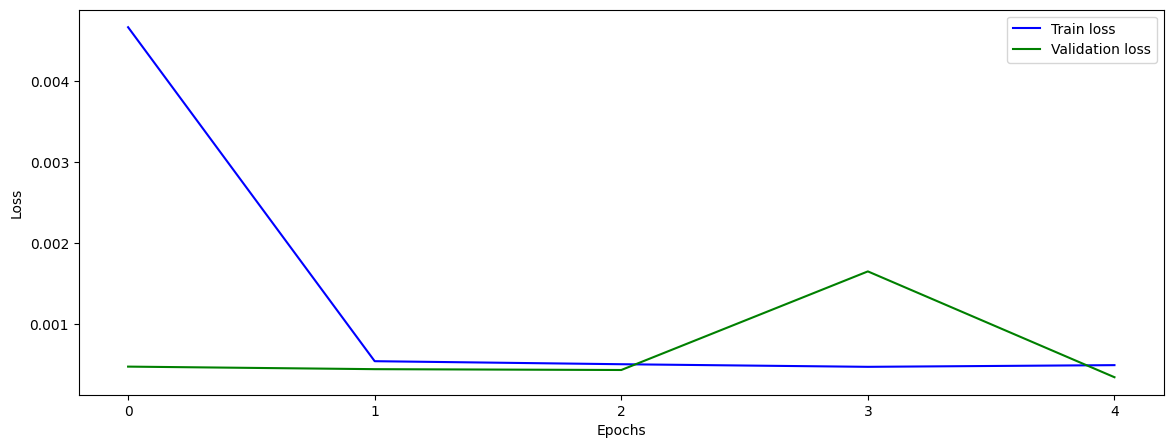

In [213]:
history = pd.read_csv('history/training-2-2.log')
cst.plot_losses(history, epochs)

Comment: bisogna vedere su più epoche

Evaluation on the test set

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

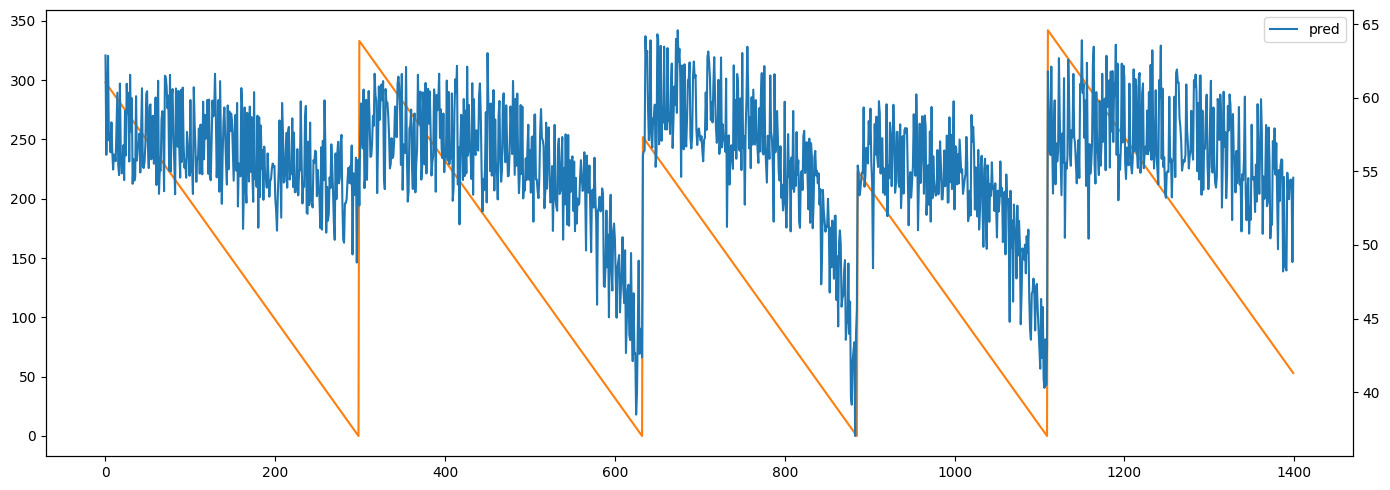

In [105]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [106]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0648
Standard Deviation of MSE: 0.0160


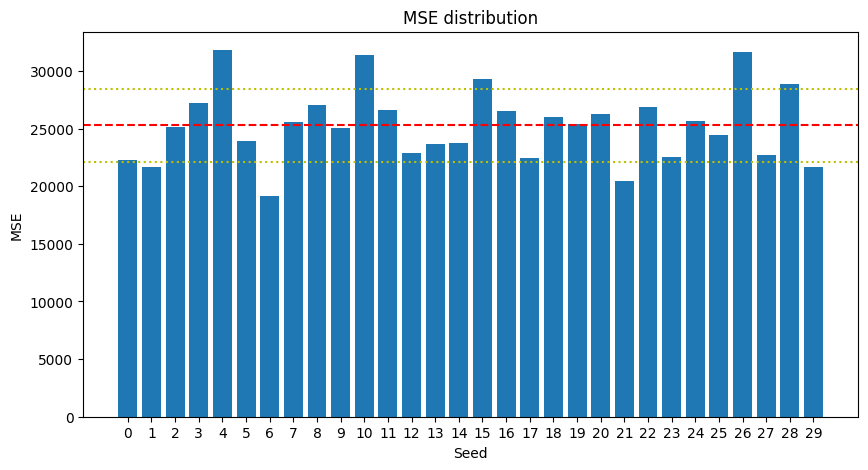

In [389]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [63]:
cst.save_results_to_excel("Task 2.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [65]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-2.xlsx')

In [66]:
pd.read_excel('./predictions/predictions-2-2.xlsx').head(10)

Seed_0     Seed_1  rul
0  78.884789  23.671032  298
1  67.454712  31.920053  297
2  73.506699  23.019428  296
3  78.012886  24.198143  295
4  67.857819  30.240625  294
5  69.601700  29.605576  293
6  69.056114  25.393200  292
7  69.369682  26.292801  291
8  67.784874  25.090641  290
9  73.800102  29.122023  289

#### 50% of unsupervised

In [107]:
tru_3 = cst.split_data(ts, tru=tru, tru_ratio=0.50)

Num. samples: 18373 (unsupervised), 15864 (test)


In [108]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru_3, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [113]:
history, predictions = train_model(train_data=tru_st, val_data=vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=0, beta=1, logger_file = 'training-2-3.log')

Epoch 1/5
541/541 [==============================] - 2s 3ms/step - loss: 0.0072 - mse: 0.0000e+00 - cst: 0.0072 - val_loss: 5.7786e-04 - val_mse: 0.0280 - val_cst: 5.7786e-04
Epoch 2/5
541/541 [==============================] - 1s 3ms/step - loss: 4.8538e-04 - mse: 0.0000e+00 - cst: 4.8538e-04 - val_loss: 4.9844e-04 - val_mse: 0.0289 - val_cst: 4.9844e-04
Epoch 3/5
541/541 [==============================] - 2s 3ms/step - loss: 4.4765e-04 - mse: 0.0000e+00 - cst: 4.4765e-04 - val_loss: 4.9353e-04 - val_mse: 0.0298 - val_cst: 4.9353e-04
Epoch 4/5
541/541 [==============================] - 1s 3ms/step - loss: 4.5155e-04 - mse: 0.0000e+00 - cst: 4.5155e-04 - val_loss: 4.3910e-04 - val_mse: 0.0326 - val_cst: 4.3910e-04
Epoch 5/5
496/496 [==============================] - 0s 375us/step
Epoch 1/5
541/541 [==============================] - 2s 3ms/step - loss: 0.0036 - mse: 0.0000e+00 - cst: 0.0036 - val_loss: 6.1194e-04 - val_mse: 0.0466 - val_cst: 6.1194e-04
Epoch 2/5
541/541 [===============

Train history visualization for the first seed

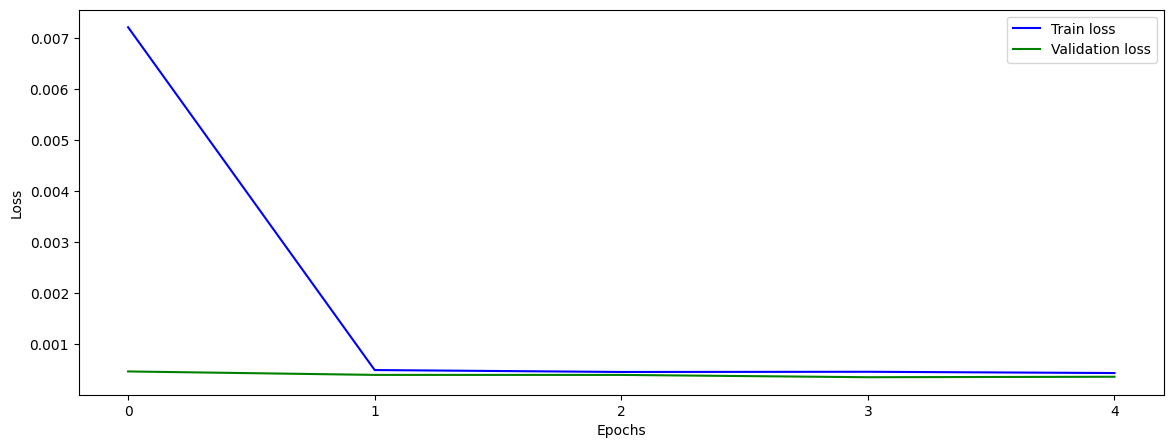

In [214]:
history = pd.read_csv('history/training-2-3.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

Evaluation on the test set

In [ ]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

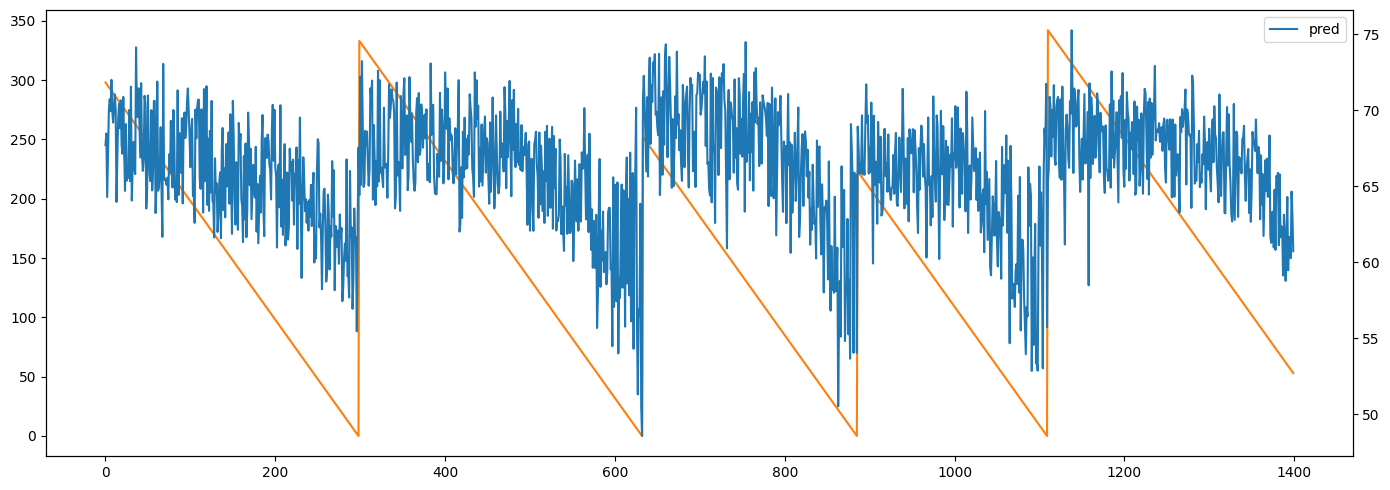

In [114]:
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [115]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0587
Standard Deviation of MSE: 0.0151


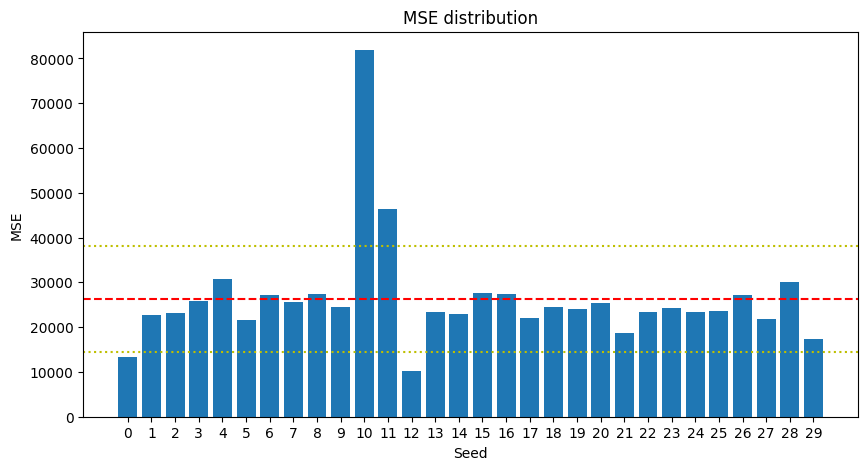

In [399]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

 Save results and predictions on excel files and show them

In [ ]:
cst.save_results_to_excel("Task 2.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [ ]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-2-3.xlsx')

In [ ]:
pd.read_excel('./predictions/predictions-2-3.xlsx').head(10)

Seed_0      Seed_1  rul
0  152.105408  191.217407  298
1  208.146179  196.382126  297
2  136.038956  181.963287  296
3  172.587631  210.188400  295
4   90.048561  181.572968  294
5  233.642746  204.206985  293
6  194.759460  171.159088  292
7  220.900040  183.582336  291
8  197.330170  182.625275  290
9  191.844040  173.469208  289

#### Results on Task 2

In [215]:
results_task2 = pd.read_excel('results.xlsx')

# tieni solo task 2.1 e 2.2
results_task2_1= results_task2[results_task2['Task'] == 'Task 2.1']
results_task2_2 = results_task2[results_task2['Task'] == 'Task 2.2']
results_task2_3 = results_task2[results_task2['Task'] == 'Task 2.3']

res_task2 = pd.concat([results_task2_1, results_task2_2, results_task2_3]).drop(columns=drop_columns)

print(tabulate(res_task2, headers='keys', showindex= False, tablefmt='psql'))

+----------+---------+---------+
| Task     |    Mean |     Std |
|----------+---------+---------|
| Task 2.1 | 18290.6 | 6147.15 |
| Task 2.2 | 18290.6 | 6147.15 |
+----------+---------+---------+


Task 2, differentlty from Task 1, uses only unsupervised data. Meaning that there is no information on the RUL while training the models. For this reason we expected that ........ . 
In comparison with Task  1, the models ..... . However, these unsupervised models understand quite well the decrasing trend of the *rul*. On the other hand, the exacgt values of the predicted *rul* are quite erroneus with respect to the true *rul*, (INIZIANO DA VALORI MOLTO PIU BASSI E NON CALANO DI TANTO)


In [216]:
# print predictions of the best model for the first machine
rul_values = pd.read_excel('./predictions/predictions-2-2.xlsx')
print(tabulate(rul_values[0:298], showindex= False, headers=['Seed 1', 'Seed 2', 'RUL'],  tablefmt='psql'))

+----------+----------+-------+
|   Seed 1 |   Seed 2 |   RUL |
|----------+----------+-------|
|  78.8848 | 23.671   |   298 |
|  67.4547 | 31.9201  |   297 |
|  73.5067 | 23.0194  |   296 |
|  78.0129 | 24.1981  |   295 |
|  67.8578 | 30.2406  |   294 |
|  69.6017 | 29.6056  |   293 |
|  69.0561 | 25.3932  |   292 |
|  69.3697 | 26.2928  |   291 |
|  67.7849 | 25.0906  |   290 |
|  73.8001 | 29.122   |   289 |
|  73.6558 | 32.0761  |   288 |
|  70.5451 | 24.7418  |   287 |
|  73.7169 | 32.264   |   286 |
|  72.9644 | 25.7989  |   285 |
|  77.0993 | 26.8583  |   284 |
|  72.5205 | 29.3357  |   283 |
|  74.0772 | 23.3007  |   282 |
|  78.8902 | 26.1224  |   281 |
|  73.4074 | 30.7765  |   280 |
|  65.772  | 27.9029  |   279 |
|  65.7197 | 30.0436  |   278 |
|  73.4905 | 22.7608  |   277 |
|  64.1129 | 30.3651  |   276 |
|  73.2559 | 28.8531  |   275 |
|  68.0916 | 28.4972  |   274 |
|  76.4119 | 25.5545  |   273 |
|  74.5554 | 25.1527  |   272 |
|  76.6822 | 20.475   |   271 |
|  69.33

Osservazioni sulle predictions stamapte: trend ok ma non si azzeccano tanto

### **Task 3**: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of supervised models. Moreover, changing the ratio will greatly influence the performances of the models. *scrivere per le combinazioni*
- a) increasing the number of supervised samples (25%, 50%, 100%), with fixed unsupervised samples, will lead to a more performing model
- b) increasing the number of unsupervised samples (25%, 50%, 100%), with fixed supervised samples, will lead to a less improvement in the performances with respect to a.



In [238]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


##### 3.1 100% unsupervised, 100% supervised

In [455]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [456]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [457]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-1.log')

Epoch 1/5
339/339 [==============================] - 3s 7ms/step - loss: 0.0341 - mse: 0.0211 - cst: 0.0130 - val_loss: 0.0266 - val_mse: 0.0244 - val_cst: 0.0022
Epoch 2/5
339/339 [==============================] - 2s 5ms/step - loss: 0.0156 - mse: 0.0138 - cst: 0.0017 - val_loss: 0.0216 - val_mse: 0.0197 - val_cst: 0.0020
Epoch 3/5
339/339 [==============================] - 2s 6ms/step - loss: 0.0138 - mse: 0.0120 - cst: 0.0018 - val_loss: 0.0193 - val_mse: 0.0174 - val_cst: 0.0019
Epoch 4/5
339/339 [==============================] - 2s 4ms/step - loss: 0.0128 - mse: 0.0109 - cst: 0.0019 - val_loss: 0.0212 - val_mse: 0.0173 - val_cst: 0.0039
Epoch 5/5
86/86 [==============================] - 0s 392us/step
Epoch 1/5
339/339 [==============================] - 3s 7ms/step - loss: 0.0242 - mse: 0.0179 - cst: 0.0063 - val_loss: 0.0334 - val_mse: 0.0304 - val_cst: 0.0030
Epoch 2/5
339/339 [==============================] - 1s 4ms/step - loss: 0.0159 - mse: 0.0140 - cst: 0.0019 - val_loss: 

Train history visualization for the first seed

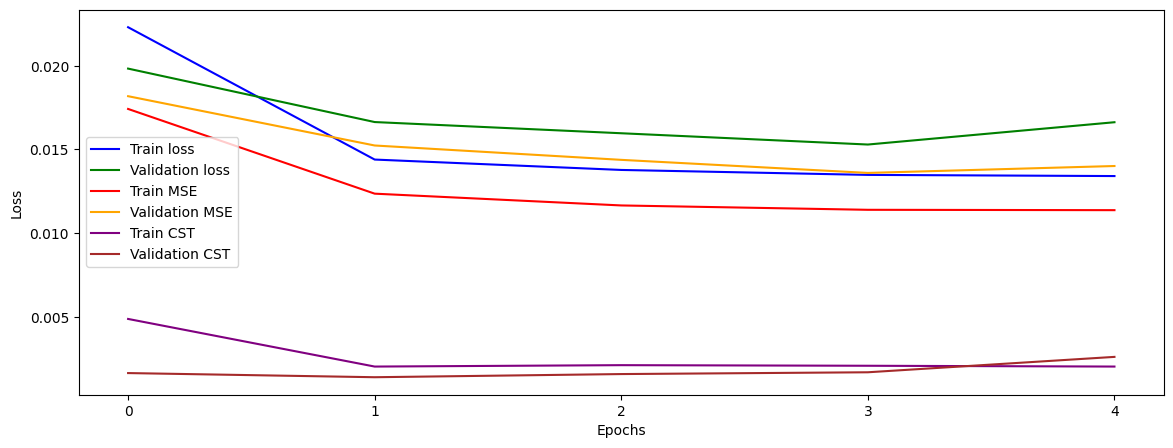

In [242]:
history = pd.read_csv('history/training-3-1.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

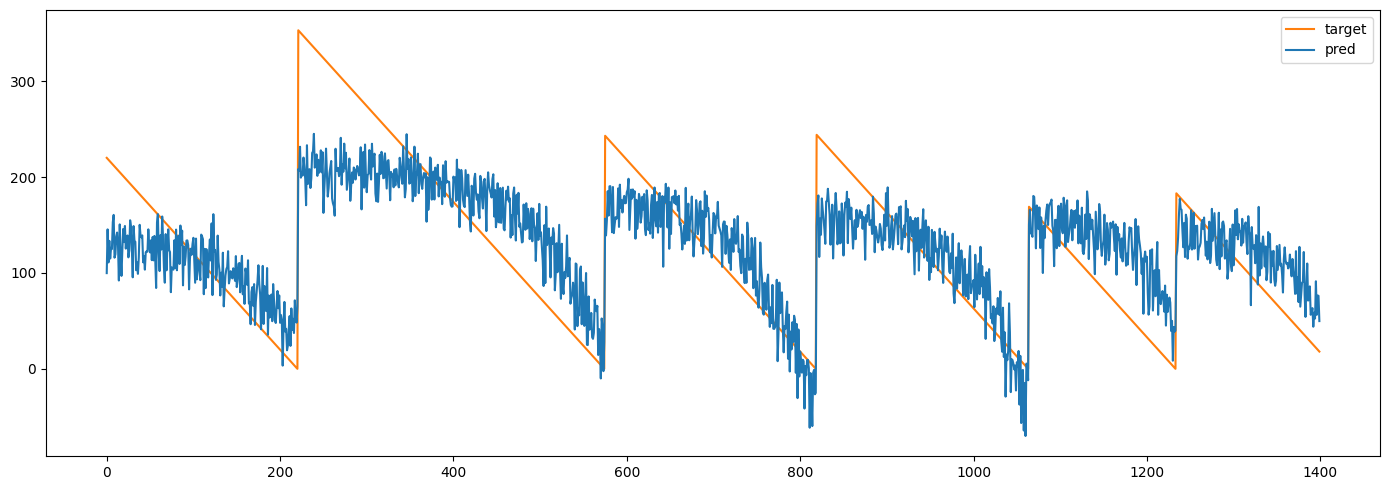

In [248]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [458]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0154
Standard Deviation of MSE: 0.0024


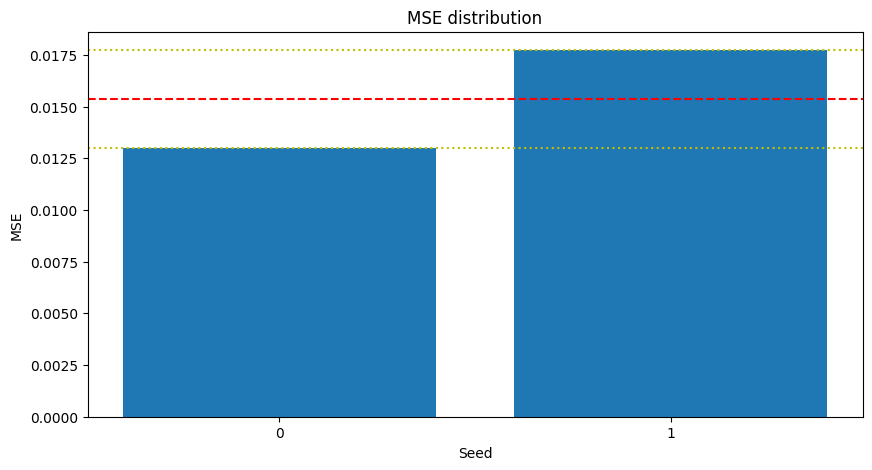

In [459]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [460]:
cst.save_results_to_excel("Task 3.1", mse_mean, mse_std, mse_seeds, excel_file_path)

In [462]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-1.xlsx')

In [463]:
pd.read_excel('./predictions/predictions-3-1.xlsx').head(10)

Seed_0  Seed_1  rul
0     105     170  220
1     140     172  219
2     112     189  218
3     109     159  217
4     114     195  216
5     111     133  215
6     122     177  214
7     125     177  213
8     129     179  212
9     118     166  211

##### 3.2 100% unsupervised, 75% supervised

In [251]:
ratio_sup = 0.75 
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 14813 (unsupervised), 15864 (validation), 2748 (test)


In [252]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [253]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-2.log')

Epoch 1/5
1137/1137 [==============================] - 4s 3ms/step - loss: 0.0205 - mse: 0.0163 - cst: 0.0042 - val_loss: 0.0199 - val_mse: 0.0183 - val_cst: 0.0015
Epoch 2/5
1137/1137 [==============================] - 4s 4ms/step - loss: 0.0143 - mse: 0.0122 - cst: 0.0021 - val_loss: 0.0172 - val_mse: 0.0158 - val_cst: 0.0014
Epoch 3/5
1137/1137 [==============================] - 5s 4ms/step - loss: 0.0131 - mse: 0.0112 - cst: 0.0019 - val_loss: 0.0151 - val_mse: 0.0136 - val_cst: 0.0016
Epoch 4/5
1137/1137 [==============================] - 4s 4ms/step - loss: 0.0126 - mse: 0.0106 - cst: 0.0020 - val_loss: 0.0149 - val_mse: 0.0136 - val_cst: 0.0013
Epoch 5/5
86/86 [==============================] - 0s 424us/step
Epoch 1/5
1137/1137 [==============================] - 5s 4ms/step - loss: 0.0190 - mse: 0.0158 - cst: 0.0033 - val_loss: 0.0213 - val_mse: 0.0198 - val_cst: 0.0015
Epoch 2/5
1137/1137 [==============================] - 4s 4ms/step - loss: 0.0151 - mse: 0.0130 - cst: 0.0021 

Train history visualization for the first seed

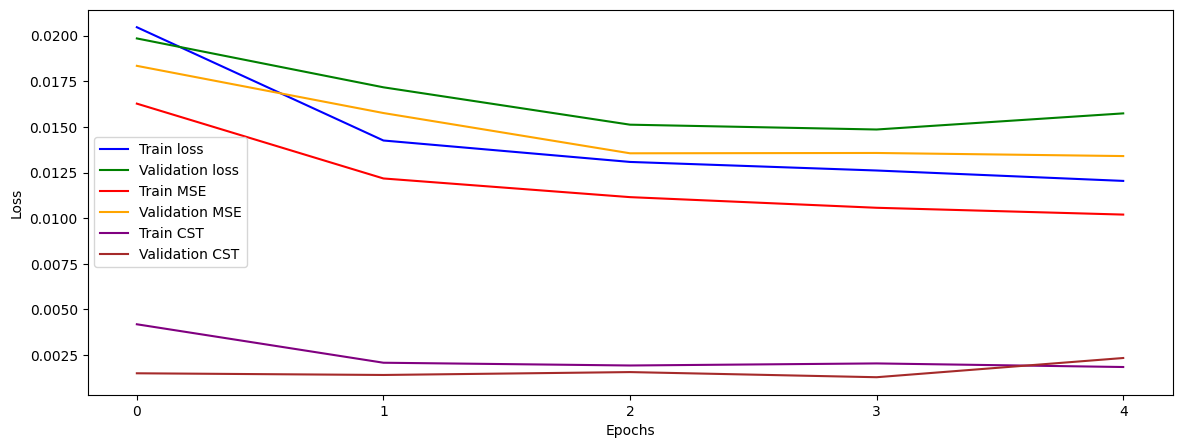

In [254]:
history = pd.read_csv('history/training-3-2.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

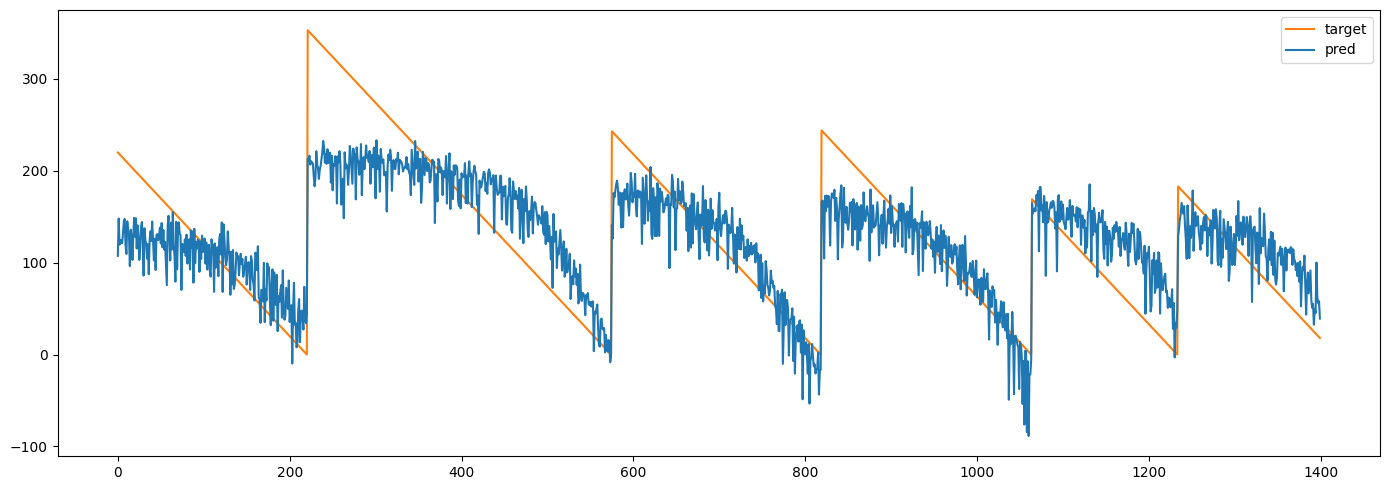

In [255]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [256]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0120
Standard Deviation of MSE: 0.0004


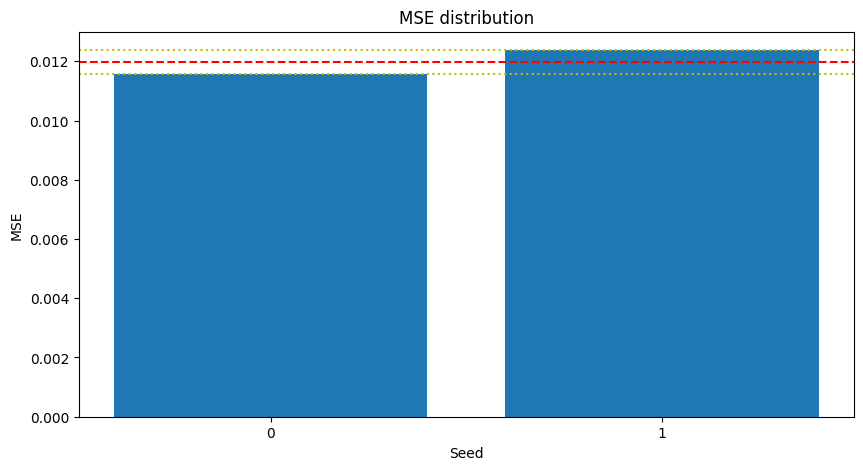

In [257]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [258]:
cst.save_results_to_excel("Task 3.2", mse_mean, mse_std, mse_seeds, excel_file_path)

In [260]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-2.xlsx')

In [261]:
pd.read_excel('./predictions/predictions-3-2.xlsx').head(10)

Seed_0      Seed_1  rul
0  107.420242  129.961746  220
1  148.043137  164.965240  219
2  119.704041  152.012100  218
3  124.183472  152.605743  217
4  124.303986  161.679642  216
5  121.083122  120.152817  215
6  131.243317  153.831329  214
7  144.322632  172.326355  213
8  147.634079  172.963715  212
9  118.938957  139.752914  211

##### 3.3 100% unsupervised, 50% supervised

In [262]:
ratio_sup = 0.50
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 10434 (supervised), 14813 (unsupervised), 2748 (test)


In [263]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [264]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-3.log')

Epoch 1/5
787/787 [==============================] - 3s 4ms/step - loss: 0.0152 - mse: 0.0103 - cst: 0.0049 - val_loss: 0.0231 - val_mse: 0.0220 - val_cst: 0.0012
Epoch 2/5
787/787 [==============================] - 3s 3ms/step - loss: 0.0091 - mse: 0.0076 - cst: 0.0015 - val_loss: 0.0239 - val_mse: 0.0227 - val_cst: 0.0012
Epoch 3/5
787/787 [==============================] - 3s 4ms/step - loss: 0.0084 - mse: 0.0069 - cst: 0.0015 - val_loss: 0.0170 - val_mse: 0.0156 - val_cst: 0.0014
Epoch 4/5
787/787 [==============================] - 3s 4ms/step - loss: 0.0081 - mse: 0.0066 - cst: 0.0015 - val_loss: 0.0219 - val_mse: 0.0188 - val_cst: 0.0031
Epoch 5/5
86/86 [==============================] - 0s 2ms/step
Epoch 1/5
787/787 [==============================] - 4s 4ms/step - loss: 0.0131 - mse: 0.0098 - cst: 0.0032 - val_loss: 0.0218 - val_mse: 0.0208 - val_cst: 0.0011
Epoch 2/5
787/787 [==============================] - 3s 3ms/step - loss: 0.0099 - mse: 0.0083 - cst: 0.0016 - val_loss: 0.

Train history visualization for the first seed

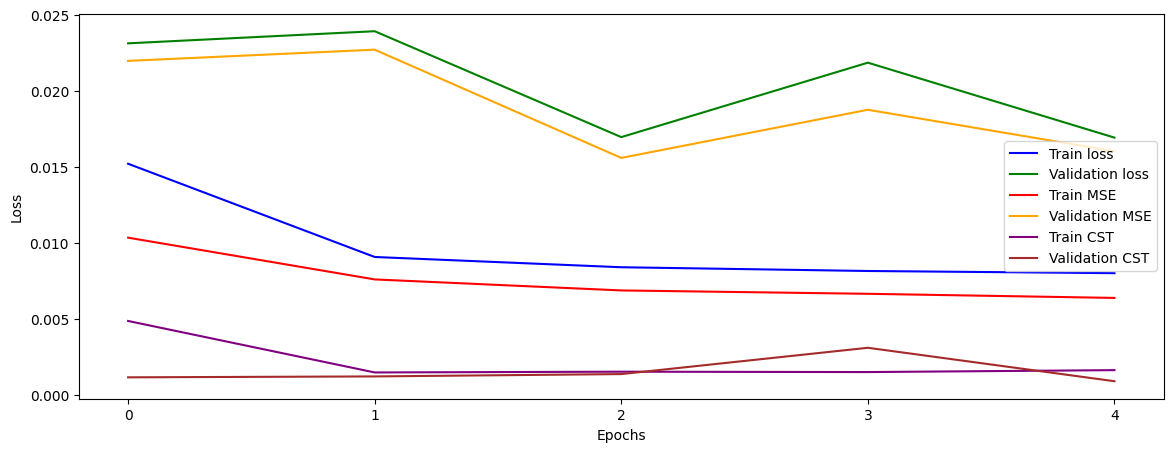

In [265]:
history = pd.read_csv('history/training-3-3.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

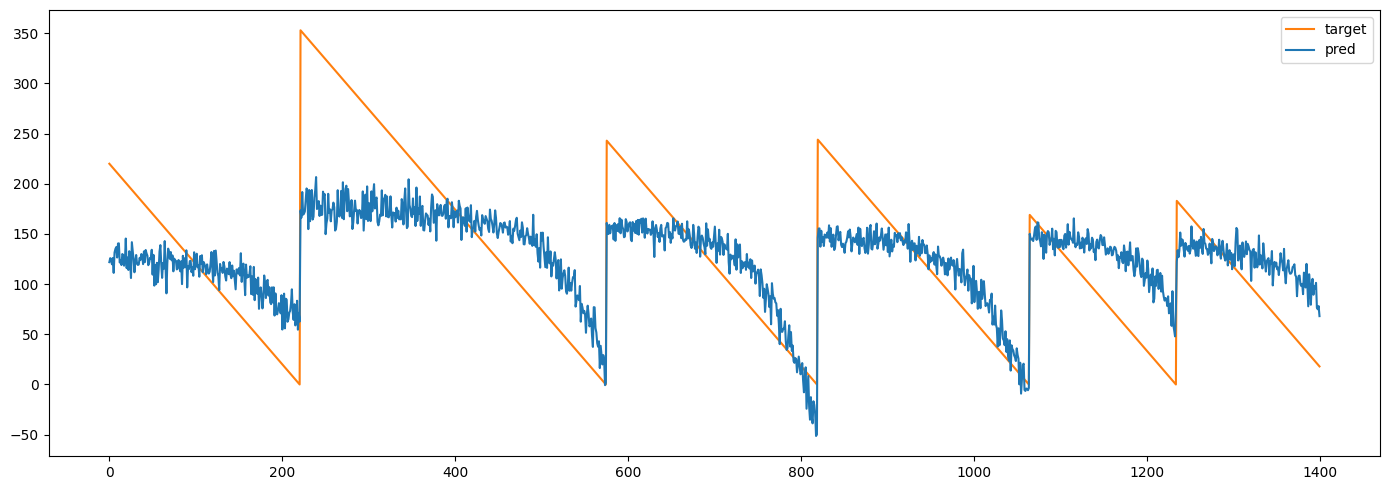

In [266]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [267]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0136
Standard Deviation of MSE: 0.0002


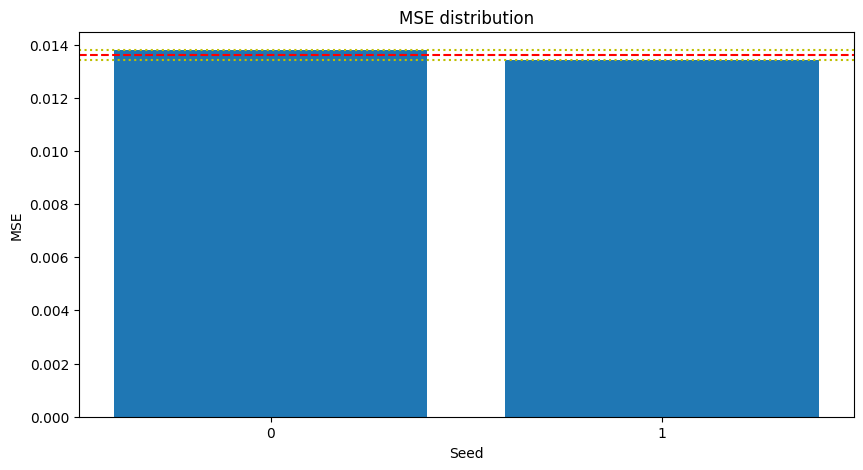

In [268]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [269]:
cst.save_results_to_excel("Task 3.3", mse_mean, mse_std, mse_seeds, excel_file_path)

In [271]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-3.xlsx')

In [272]:
pd.read_excel('./predictions/predictions-3-3.xlsx').head(10)

Seed_0      Seed_1  rul
0  121.908508  104.884293  220
1  125.867371  137.161469  219
2  125.076622  121.713196  218
3  119.819710  118.356033  217
4  126.026466  125.869827  216
5  111.222015  103.351807  215
6  131.521286  119.481743  214
7  135.043152  139.883530  213
8  136.944534  139.545258  212
9  126.530441  108.947029  211

##### 3.4 100% unsupervised, 25% supervised

In [274]:
ratio_sup = 0.25
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 652 (supervised), 14813 (unsupervised), 15864 (validation),2748 (test)


In [275]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [276]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s,  test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-4.log')

Epoch 1/5
461/461 [==============================] - 2s 4ms/step - loss: 0.0098 - mse: 0.0016 - cst: 0.0082 - val_loss: 0.0315 - val_mse: 0.0308 - val_cst: 7.7026e-04
Epoch 2/5
461/461 [==============================] - 2s 4ms/step - loss: 0.0021 - mse: 0.0014 - cst: 6.5096e-04 - val_loss: 0.0266 - val_mse: 0.0258 - val_cst: 8.3939e-04
Epoch 3/5
461/461 [==============================] - 2s 4ms/step - loss: 0.0020 - mse: 0.0013 - cst: 6.5932e-04 - val_loss: 0.0268 - val_mse: 0.0260 - val_cst: 7.5596e-04
Epoch 4/5
461/461 [==============================] - 3s 5ms/step - loss: 0.0020 - mse: 0.0013 - cst: 7.1706e-04 - val_loss: 0.0254 - val_mse: 0.0248 - val_cst: 5.9389e-04
Epoch 5/5
86/86 [==============================] - 0s 440us/step
Epoch 1/5
461/461 [==============================] - 3s 6ms/step - loss: 0.0054 - mse: 0.0014 - cst: 0.0040 - val_loss: 0.0404 - val_mse: 0.0387 - val_cst: 0.0017
Epoch 2/5
461/461 [==============================] - 2s 4ms/step - loss: 0.0022 - mse: 0.001

Train history visualization for the first seed

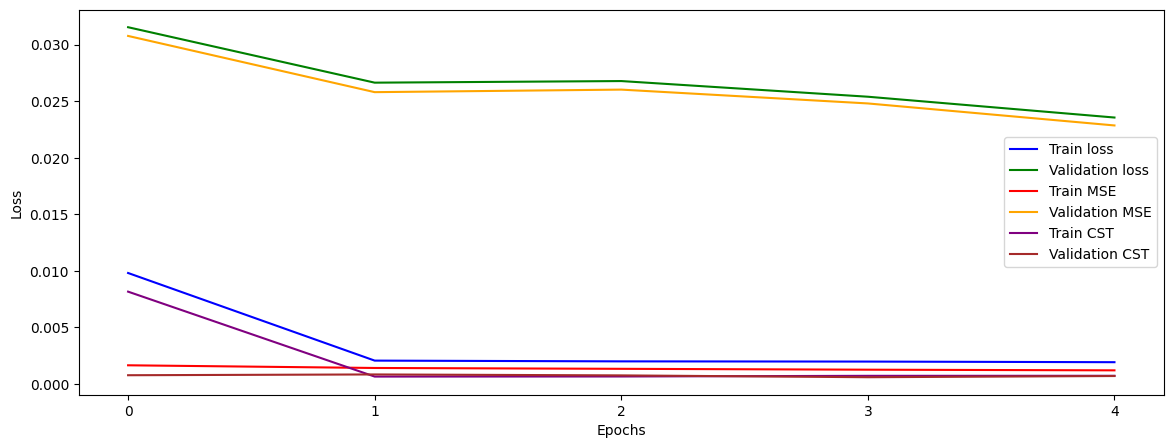

In [277]:
history = pd.read_csv('history/training-3-4.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

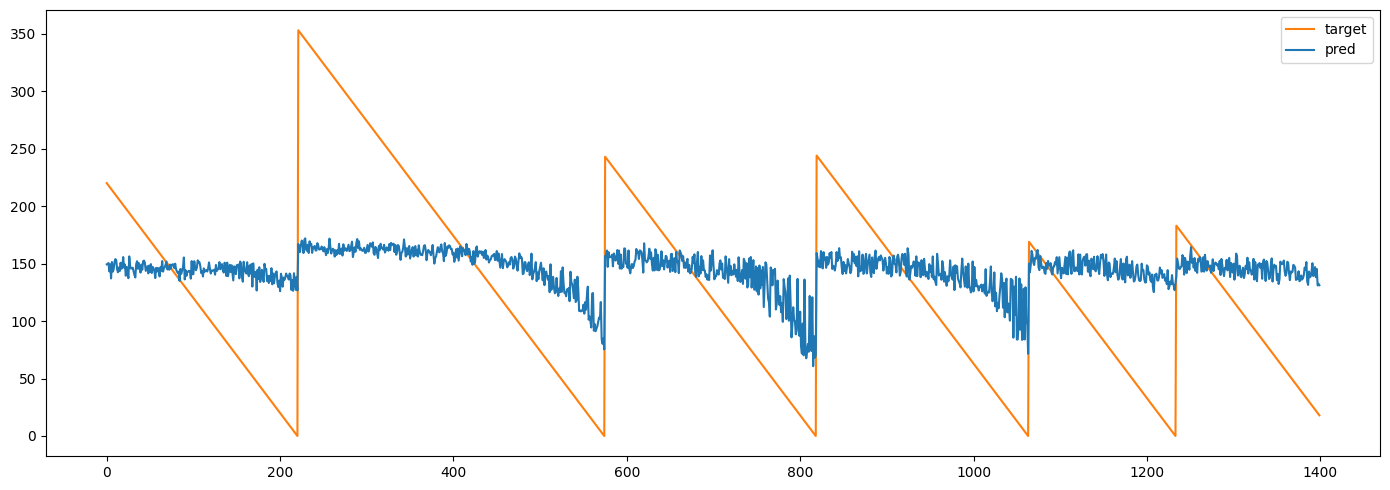

In [278]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

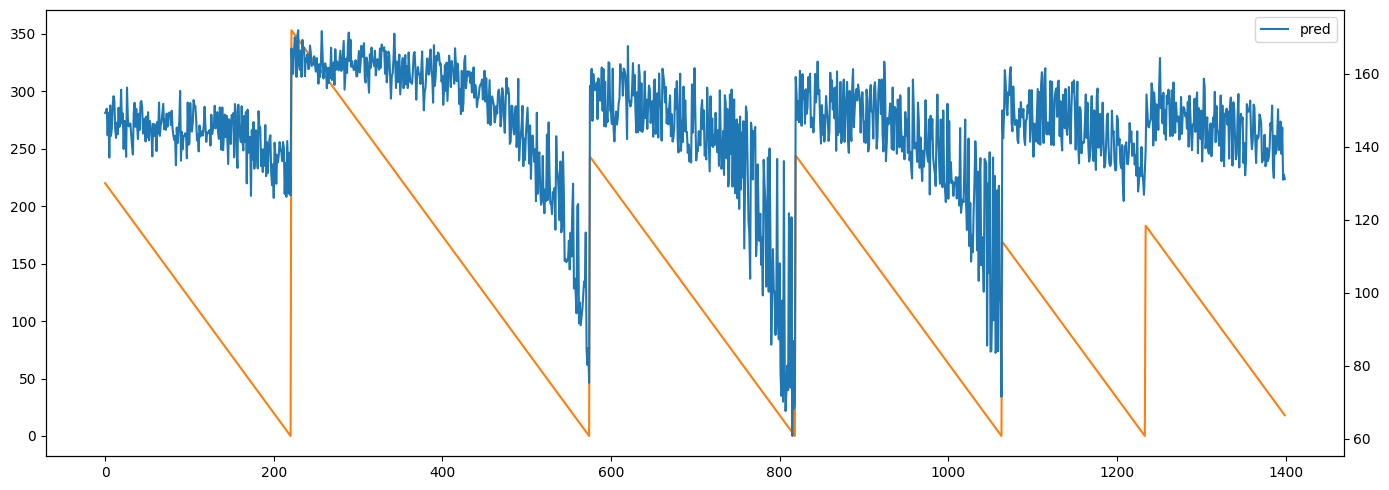

In [279]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [280]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0229
Standard Deviation of MSE: 0.0015


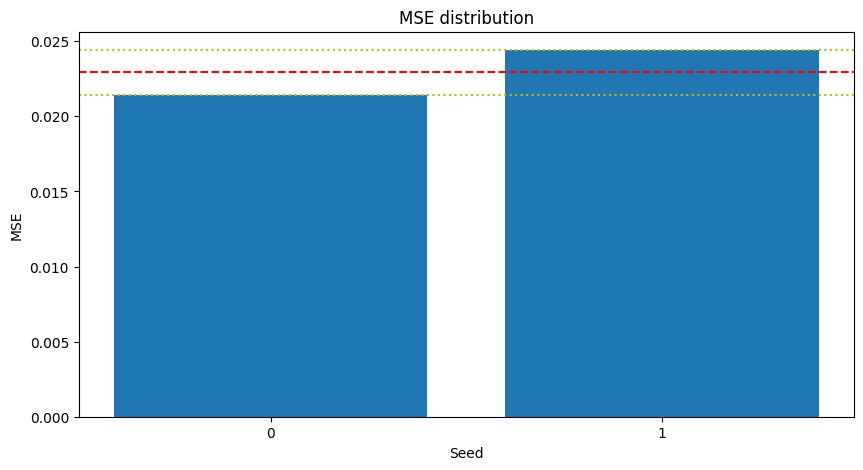

In [281]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [282]:
cst.save_results_to_excel("Task 3.4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [284]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-4.xlsx')

In [285]:
pd.read_excel('./predictions/predictions-3-4.xlsx').head(10)

Seed_0      Seed_1  rul
0  149.326141  175.813751  220
1  149.640823  179.530975  219
2  150.490082  183.947586  218
3  143.201645  173.197159  217
4  149.366135  182.233032  216
5  137.090408  160.680771  215
6  151.372375  168.872879  214
7  143.028687  166.912994  213
8  145.118683  168.889771  212
9  151.400558  169.465988  211

##### 3.5 100% supervised, 50% unsupervised

In [330]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [331]:
ratio_unsup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [332]:
trs_s, tru_s, ts_s, vs_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [333]:
history, predictions = train_model(train_data=trsu_s,  val_data =vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-5.log')

Epoch 1/5
1151/1151 [==============================] - 3s 3ms/step - loss: 0.0258 - mse: 0.0206 - cst: 0.0051 - val_loss: 0.0161 - val_mse: 0.0141 - val_cst: 0.0020
Epoch 2/5
1151/1151 [==============================] - 3s 3ms/step - loss: 0.0171 - mse: 0.0149 - cst: 0.0022 - val_loss: 0.0155 - val_mse: 0.0132 - val_cst: 0.0023
Epoch 3/5
1151/1151 [==============================] - 3s 3ms/step - loss: 0.0161 - mse: 0.0138 - cst: 0.0023 - val_loss: 0.0133 - val_mse: 0.0115 - val_cst: 0.0018
Epoch 4/5
1151/1151 [==============================] - 3s 3ms/step - loss: 0.0157 - mse: 0.0135 - cst: 0.0022 - val_loss: 0.0134 - val_mse: 0.0115 - val_cst: 0.0019
Epoch 5/5
496/496 [==============================] - 0s 423us/step
Epoch 1/5
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0238 - mse: 0.0204 - cst: 0.0034 - val_loss: 0.0174 - val_mse: 0.0157 - val_cst: 0.0016
Epoch 2/5
1151/1151 [==============================] - 4s 3ms/step - loss: 0.0184 - mse: 0.0162 - cst: 0.002

Train history visualization for the first seed

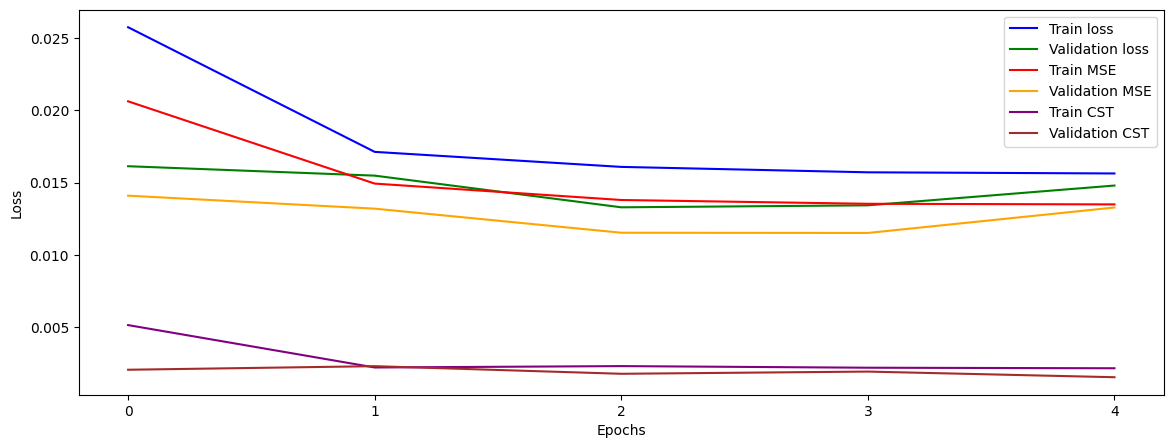

In [334]:
history = pd.read_csv('history/training-3-5.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

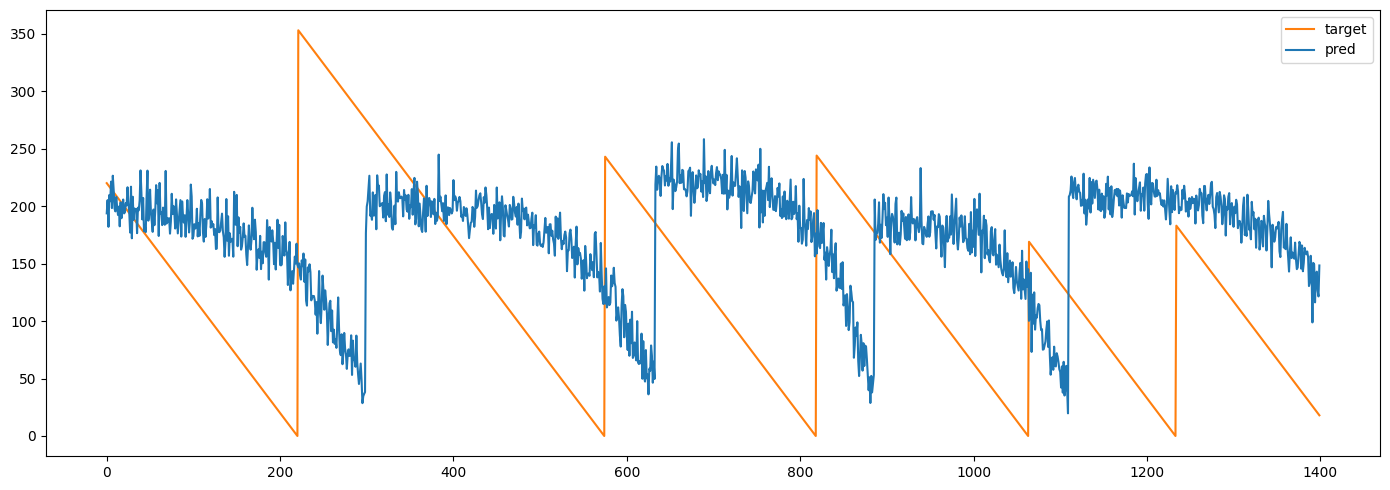

In [335]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

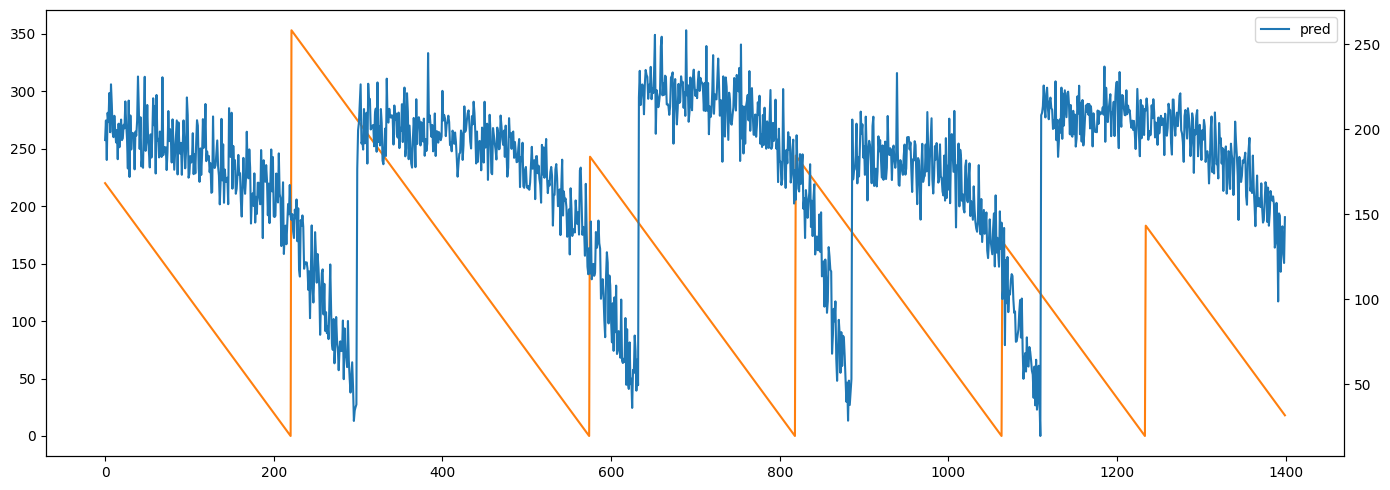

In [336]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [294]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0147
Standard Deviation of MSE: 0.0004


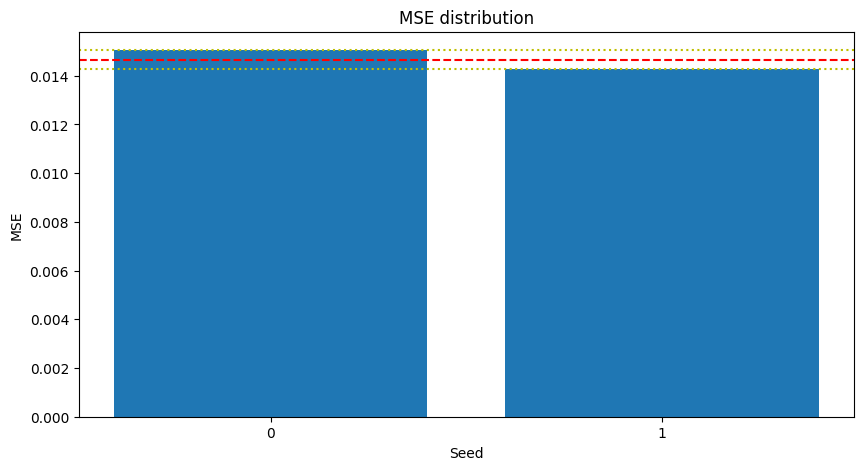

In [295]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [296]:
cst.save_results_to_excel("Task 3.5", mse_mean, mse_std, mse_seeds, excel_file_path)

In [299]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-5.xlsx')

In [302]:
pd.read_excel('./predictions/predictions-3-5.xlsx').head(10)

Seed_0      Seed_1    rul
0  193.711884  147.806641  220.0
1  205.218201  176.001556  219.0
2  182.000565  143.445984  218.0
3  209.724640  166.859421  217.0
4  204.260025  194.132385  216.0
5  221.344879  191.381454  215.0
6  198.311325  157.105316  214.0
7  226.467636  174.082916  213.0
8  214.360199  170.159409  212.0
9  197.894348  162.149017  211.0

##### 3.6 100% supervised, 75% unsupervised

In [303]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [304]:
ratio_unsup = 0.75 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [305]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [306]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-6.log')

Epoch 1/5
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0244 - mse: 0.0193 - cst: 0.0050 - val_loss: 0.0189 - val_mse: 0.0173 - val_cst: 0.0016
Epoch 2/5
1264/1264 [==============================] - 4s 4ms/step - loss: 0.0160 - mse: 0.0138 - cst: 0.0021 - val_loss: 0.0157 - val_mse: 0.0143 - val_cst: 0.0013
Epoch 3/5
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0147 - mse: 0.0126 - cst: 0.0021 - val_loss: 0.0194 - val_mse: 0.0148 - val_cst: 0.0046
Epoch 4/5
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0123 - cst: 0.0021 - val_loss: 0.0157 - val_mse: 0.0141 - val_cst: 0.0016
Epoch 5/5
86/86 [==============================] - 0s 400us/step
Epoch 1/5
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0213 - mse: 0.0181 - cst: 0.0032 - val_loss: 0.0207 - val_mse: 0.0182 - val_cst: 0.0026
Epoch 2/5
1264/1264 [==============================] - 4s 3ms/step - loss: 0.0174 - mse: 0.0149 - cst: 0.0025 

Train history visualization for the first seed

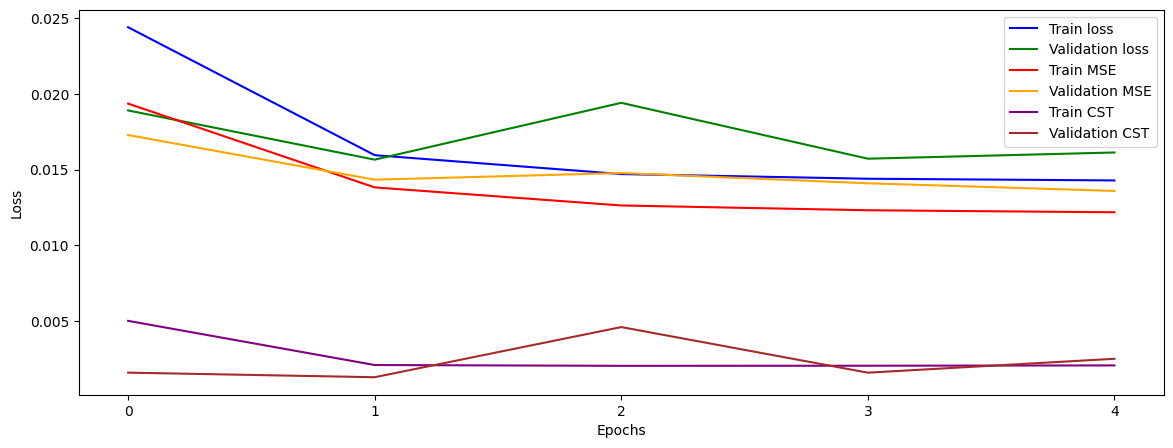

In [307]:
history = pd.read_csv('history/training-3-6.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

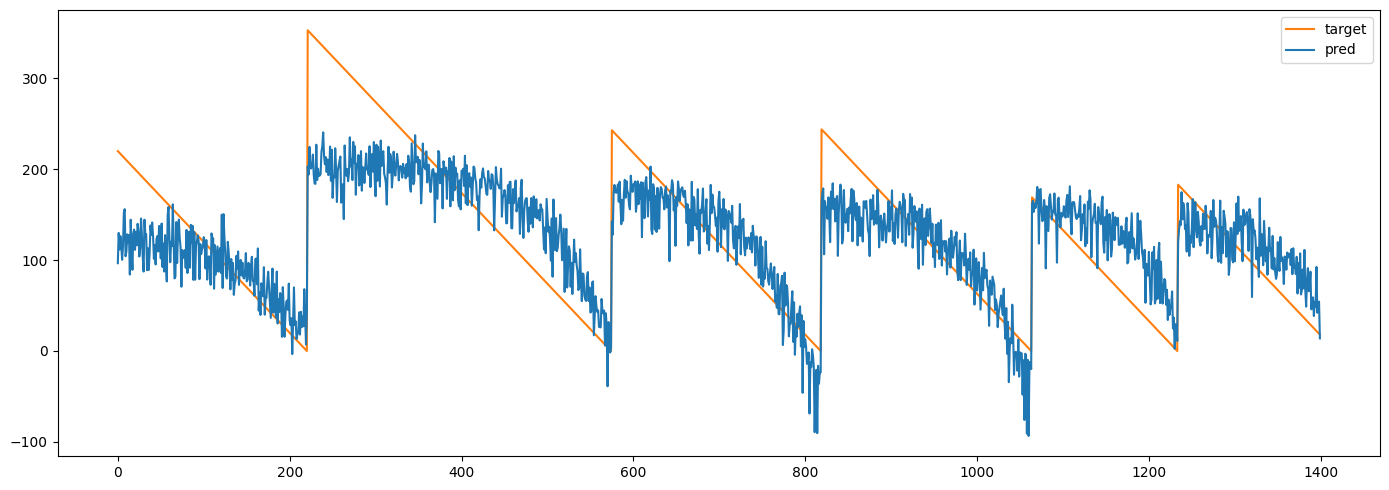

In [310]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [311]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0124
Standard Deviation of MSE: 0.0009


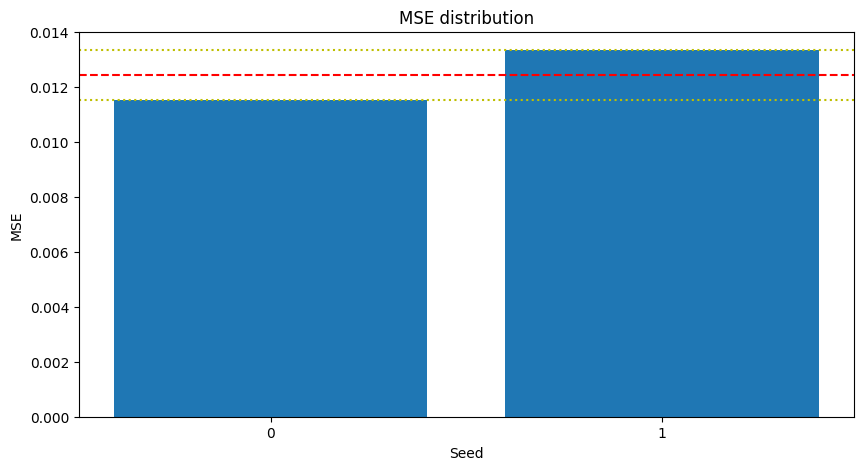

In [312]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [313]:
cst.save_results_to_excel("Task 3.6", mse_mean, mse_std, mse_seeds, excel_file_path)

In [316]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-6.xlsx')

In [317]:
pd.read_excel('./predictions/predictions-3-6.xlsx').head(10)

Seed_0      Seed_1  rul
0   96.657654  155.657776  220
1  129.961761  168.790512  219
2  111.777122  174.686981  218
3  126.504356  143.927597  217
4  115.457504  176.452057  216
5  100.382248  125.290199  215
6  114.963303  153.649002  214
7  151.769348  183.630692  213
8  156.082275  181.914612  212
9  104.287102  139.161087  211

##### 3.7 100% supervised, 25% unsupervised

In [318]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [319]:
ratio_unsup = 0.25 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 27824 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [320]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [321]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-7.log')

Epoch 1/5
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0298 - mse: 0.0238 - cst: 0.0060 - val_loss: 0.0198 - val_mse: 0.0175 - val_cst: 0.0023
Epoch 2/5
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0182 - mse: 0.0160 - cst: 0.0021 - val_loss: 0.0159 - val_mse: 0.0142 - val_cst: 0.0017
Epoch 3/5
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0176 - mse: 0.0153 - cst: 0.0023 - val_loss: 0.0153 - val_mse: 0.0136 - val_cst: 0.0017
Epoch 4/5
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0170 - mse: 0.0147 - cst: 0.0022 - val_loss: 0.0144 - val_mse: 0.0126 - val_cst: 0.0017
Epoch 5/5
86/86 [==============================] - 0s 400us/step
Epoch 1/5
1041/1041 [==============================] - 4s 3ms/step - loss: 0.0259 - mse: 0.0223 - cst: 0.0037 - val_loss: 0.0210 - val_mse: 0.0183 - val_cst: 0.0027
Epoch 2/5
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0200 - mse: 0.0177 - cst: 0.0024 

Train history visualization for the first seed

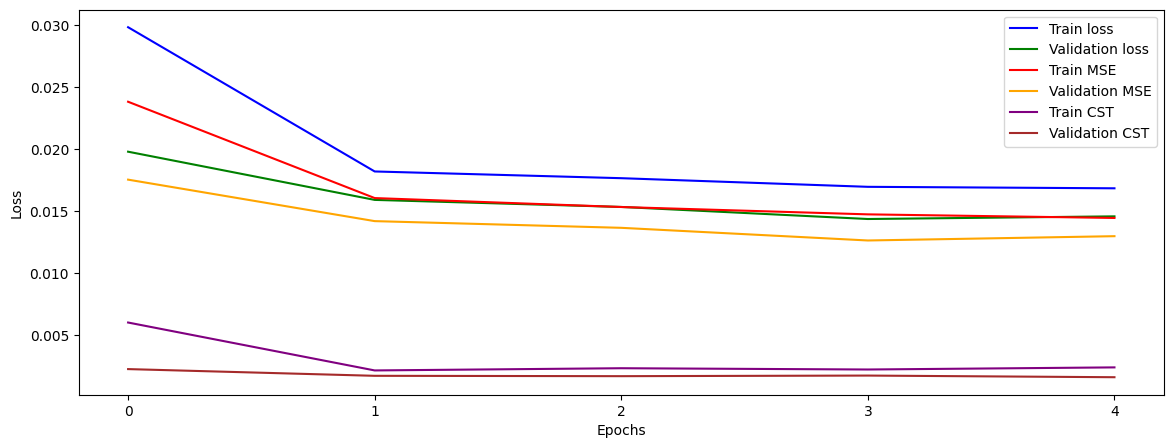

In [322]:
history = pd.read_csv('history/training-3-7.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

In [323]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [324]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0112
Standard Deviation of MSE: 0.0001


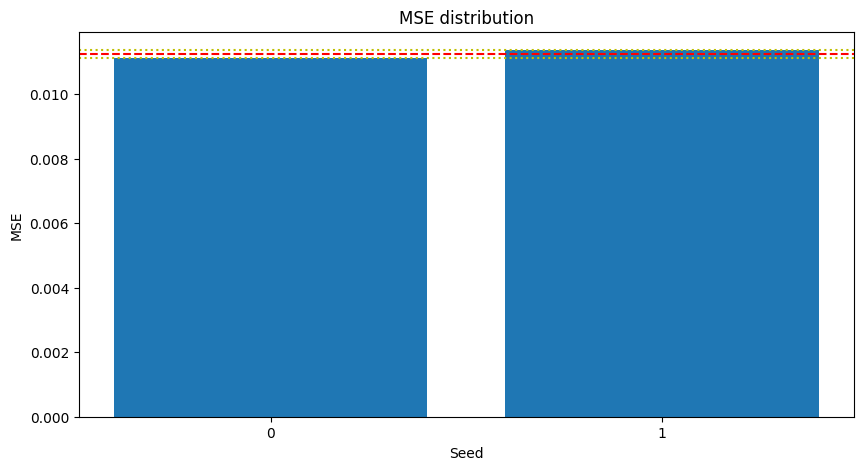

In [325]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [326]:
cst.save_results_to_excel("Task 3.7", mse_mean, mse_std, mse_seeds, excel_file_path)

In [328]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-7.xlsx')

In [329]:
pd.read_excel('./predictions/predictions-3-7.xlsx').head(10)

Seed_0      Seed_1  rul
0  114.885437  122.239777  220
1  131.244247  140.954453  219
2  128.166595  142.931168  218
3  125.638306  137.621765  217
4  133.091278  144.003021  216
5  103.630600   91.758659  215
6  137.561264  132.133301  214
7  152.198944  158.303268  213
8  154.372498  157.991928  212
9  128.713745  114.761398  211

##### 3.8 75% unsupervised, 75% supervised

In [338]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [339]:
ratio_unsup = 0.75 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 20868 (supervised), 11109 (unsupervised), 15864 (validation),2748 (test)


In [340]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [341]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-8.log')

Epoch 1/5
1028/1028 [==============================] - 4s 4ms/step - loss: 0.0240 - mse: 0.0184 - cst: 0.0056 - val_loss: 0.0212 - val_mse: 0.0184 - val_cst: 0.0027
Epoch 2/5
1028/1028 [==============================] - 4s 4ms/step - loss: 0.0148 - mse: 0.0128 - cst: 0.0020 - val_loss: 0.0184 - val_mse: 0.0164 - val_cst: 0.0020
Epoch 3/5
1028/1028 [==============================] - 5s 5ms/step - loss: 0.0138 - mse: 0.0117 - cst: 0.0021 - val_loss: 0.0174 - val_mse: 0.0155 - val_cst: 0.0019
Epoch 4/5
1028/1028 [==============================] - 4s 4ms/step - loss: 0.0137 - mse: 0.0115 - cst: 0.0022 - val_loss: 0.0167 - val_mse: 0.0139 - val_cst: 0.0028
Epoch 5/5
86/86 [==============================] - 0s 439us/step
Epoch 1/5
1028/1028 [==============================] - 4s 3ms/step - loss: 0.0206 - mse: 0.0170 - cst: 0.0036 - val_loss: 0.0206 - val_mse: 0.0190 - val_cst: 0.0016
Epoch 2/5
1028/1028 [==============================] - 4s 4ms/step - loss: 0.0165 - mse: 0.0143 - cst: 0.0022 

Train history visualization for the first seed

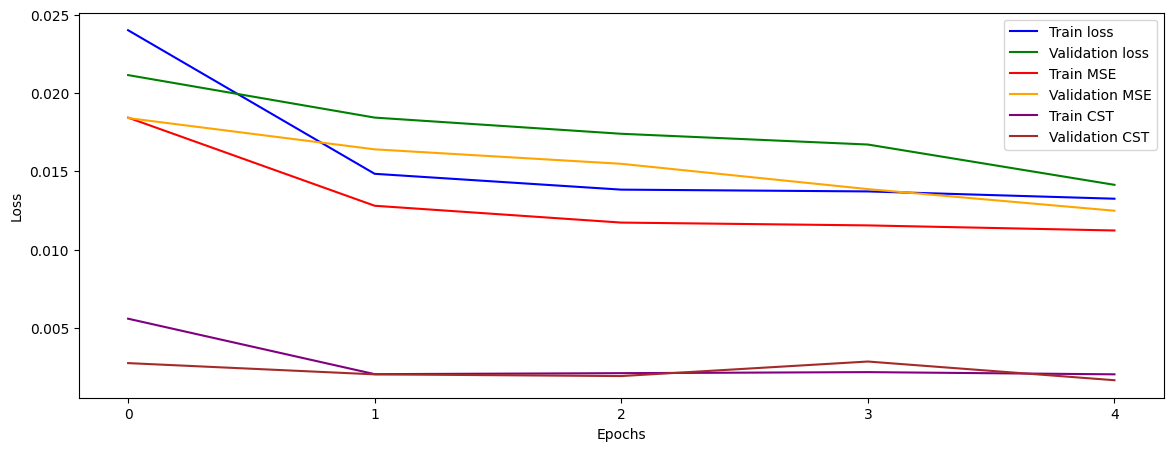

In [347]:
history = pd.read_csv('history/training-3-8.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

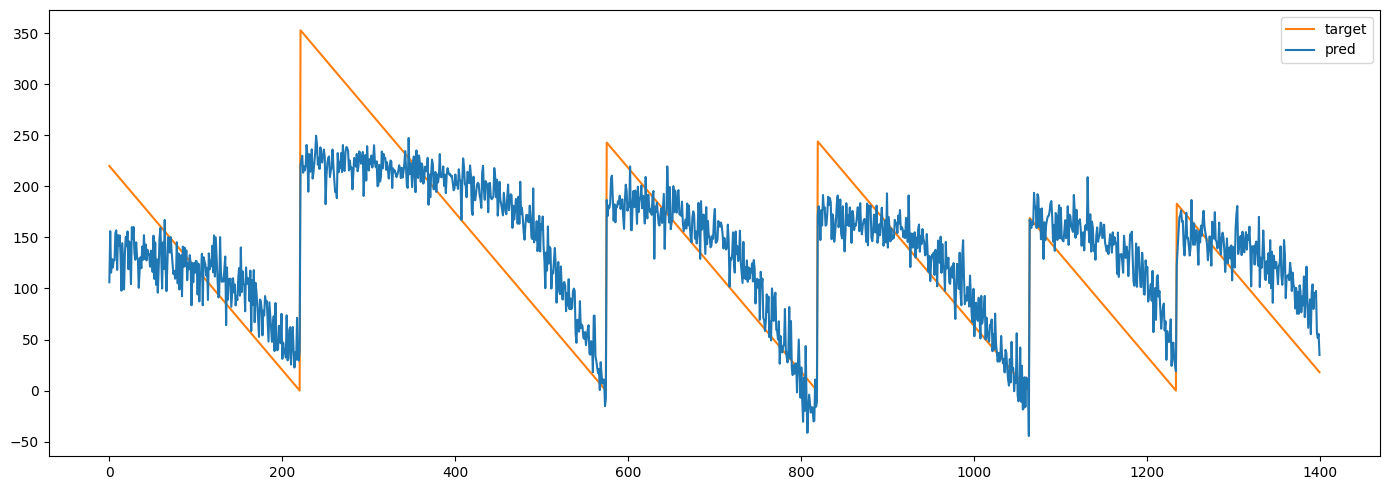

In [348]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [349]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0114
Standard Deviation of MSE: 0.0005


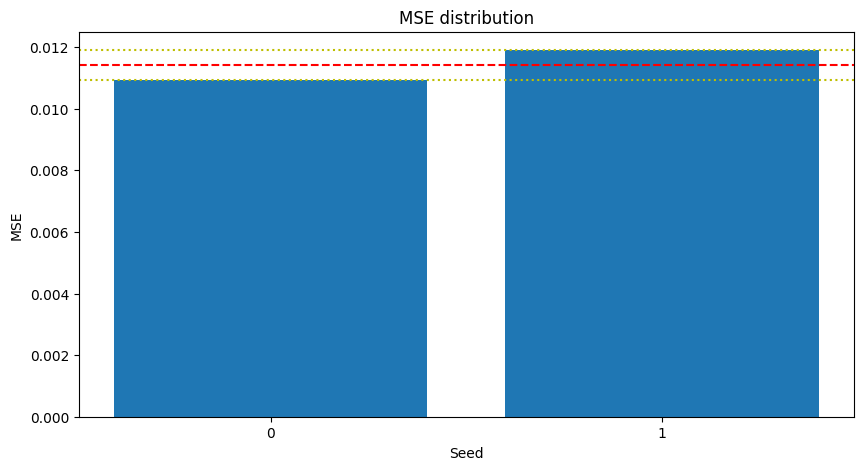

In [350]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [351]:
cst.save_results_to_excel("Task 3.8", mse_mean, mse_std, mse_seeds, excel_file_path)

In [353]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-8.xlsx')

In [354]:
pd.read_excel('./predictions/predictions-3-8.xlsx').head(10)

Seed_0      Seed_1  rul
0  106.111496   97.275055  220
1  156.163010  144.595810  219
2  115.595757  117.104126  218
3  128.906967  138.810104  217
4  120.516579  124.510292  216
5  128.121048   99.196564  215
6  127.732788  122.920525  214
7  154.497818  154.067627  213
8  156.954086  154.953598  212
9  118.174057  109.646835  211

##### 3.9 75% unsupervised, 50% supervised

In [355]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [356]:
ratio_unsup = 0.75 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation),{len(ts)} (test)')

Num. samples: 13912 (supervised), 11109 (unsupervised), 15864 (validation),2748 (test)


In [357]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [358]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-9.log')

Epoch 1/5
795/795 [==============================] - 3s 3ms/step - loss: 0.0227 - mse: 0.0171 - cst: 0.0056 - val_loss: 0.0230 - val_mse: 0.0208 - val_cst: 0.0022
Epoch 2/5
795/795 [==============================] - 3s 4ms/step - loss: 0.0147 - mse: 0.0129 - cst: 0.0018 - val_loss: 0.0201 - val_mse: 0.0183 - val_cst: 0.0018
Epoch 3/5
795/795 [==============================] - 3s 4ms/step - loss: 0.0129 - mse: 0.0111 - cst: 0.0018 - val_loss: 0.0163 - val_mse: 0.0150 - val_cst: 0.0012
Epoch 4/5
795/795 [==============================] - 4s 4ms/step - loss: 0.0125 - mse: 0.0106 - cst: 0.0018 - val_loss: 0.0173 - val_mse: 0.0162 - val_cst: 0.0011
Epoch 5/5
86/86 [==============================] - 0s 817us/step
Epoch 1/5
795/795 [==============================] - 3s 3ms/step - loss: 0.0191 - mse: 0.0153 - cst: 0.0038 - val_loss: 0.0216 - val_mse: 0.0201 - val_cst: 0.0016
Epoch 2/5
795/795 [==============================] - 3s 4ms/step - loss: 0.0152 - mse: 0.0133 - cst: 0.0020 - val_loss: 

Train history visualization for the first seed

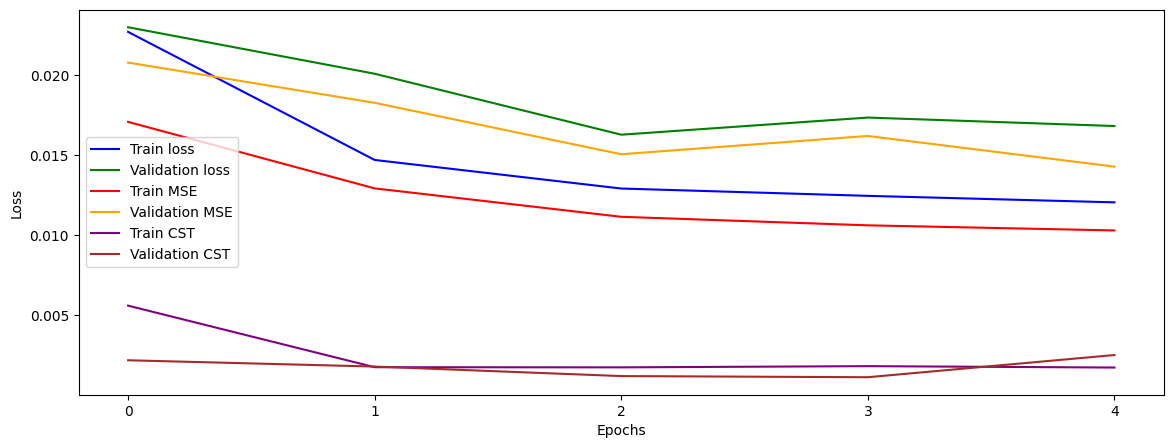

In [359]:
history = pd.read_csv('history/training-3-9.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

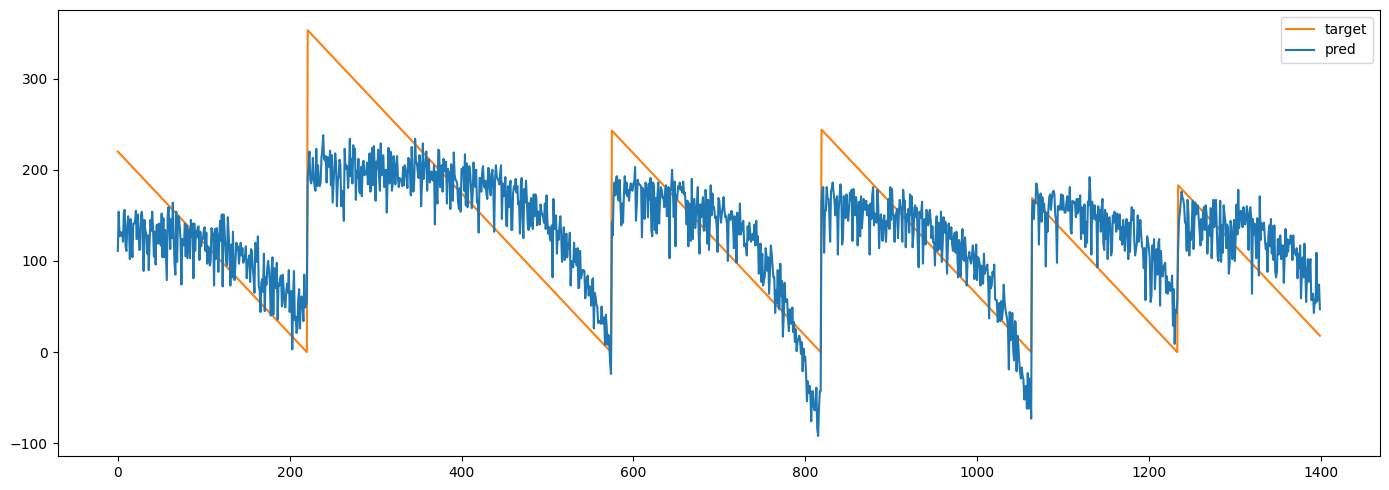

In [360]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [361]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0123
Standard Deviation of MSE: 0.0003


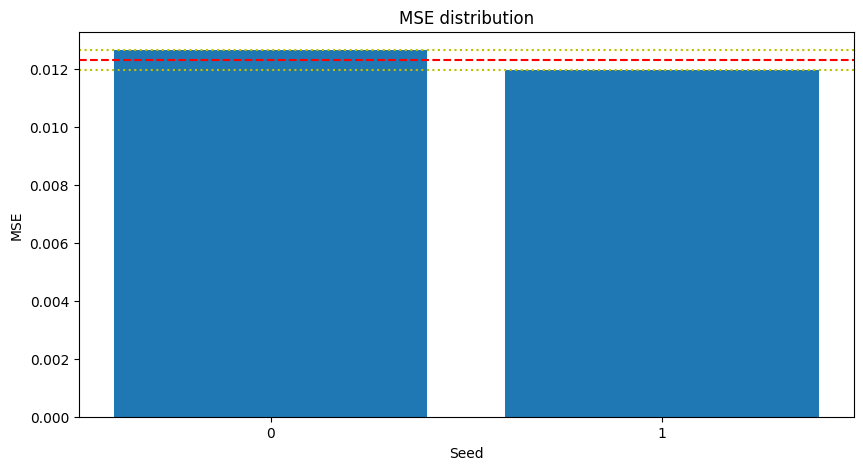

In [362]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [363]:
cst.save_results_to_excel("Task 3.9", mse_mean, mse_std, mse_seeds, excel_file_path)

In [365]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-9.xlsx')

In [366]:
pd.read_excel('./predictions/predictions-3-9.xlsx').head(10)

Seed_0  Seed_1  rul
0     111      94  220
1     154     143  219
2     127     111  218
3     132     113  217
4     128     116  216
5     131     104  215
6     121     124  214
7     153     147  213
8     156     147  212
9     116     110  211

##### 3.10 75% unsupervised, 25% supervised

In [367]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [368]:
ratio_unsup = 0.75 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 11109 (unsupervised), 15864 (validation), 2748 (test)


In [369]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [370]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-10.log')

Epoch 1/5
562/562 [==============================] - 3s 4ms/step - loss: 0.0207 - mse: 0.0126 - cst: 0.0082 - val_loss: 0.0256 - val_mse: 0.0239 - val_cst: 0.0017
Epoch 2/5
562/562 [==============================] - 2s 4ms/step - loss: 0.0100 - mse: 0.0086 - cst: 0.0014 - val_loss: 0.0226 - val_mse: 0.0208 - val_cst: 0.0018
Epoch 3/5
562/562 [==============================] - 2s 4ms/step - loss: 0.0089 - mse: 0.0074 - cst: 0.0014 - val_loss: 0.0208 - val_mse: 0.0184 - val_cst: 0.0024
Epoch 4/5
562/562 [==============================] - 2s 4ms/step - loss: 0.0086 - mse: 0.0070 - cst: 0.0016 - val_loss: 0.0183 - val_mse: 0.0167 - val_cst: 0.0015
Epoch 5/5
86/86 [==============================] - 0s 405us/step
Epoch 1/5
562/562 [==============================] - 3s 4ms/step - loss: 0.0148 - mse: 0.0102 - cst: 0.0046 - val_loss: 0.0240 - val_mse: 0.0220 - val_cst: 0.0020
Epoch 2/5
562/562 [==============================] - 2s 4ms/step - loss: 0.0100 - mse: 0.0084 - cst: 0.0016 - val_loss: 

Train history visualization for the first seed

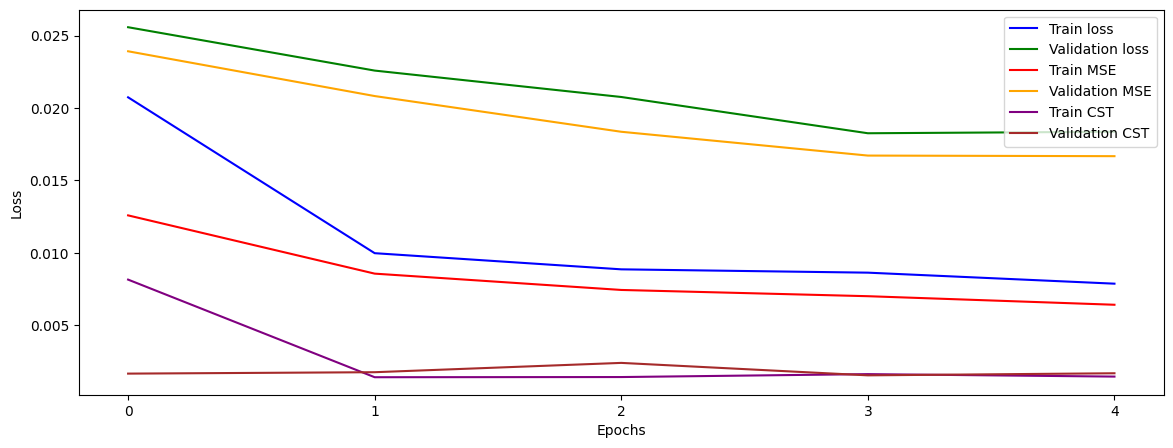

In [372]:
history = pd.read_csv('history/training-3-10.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

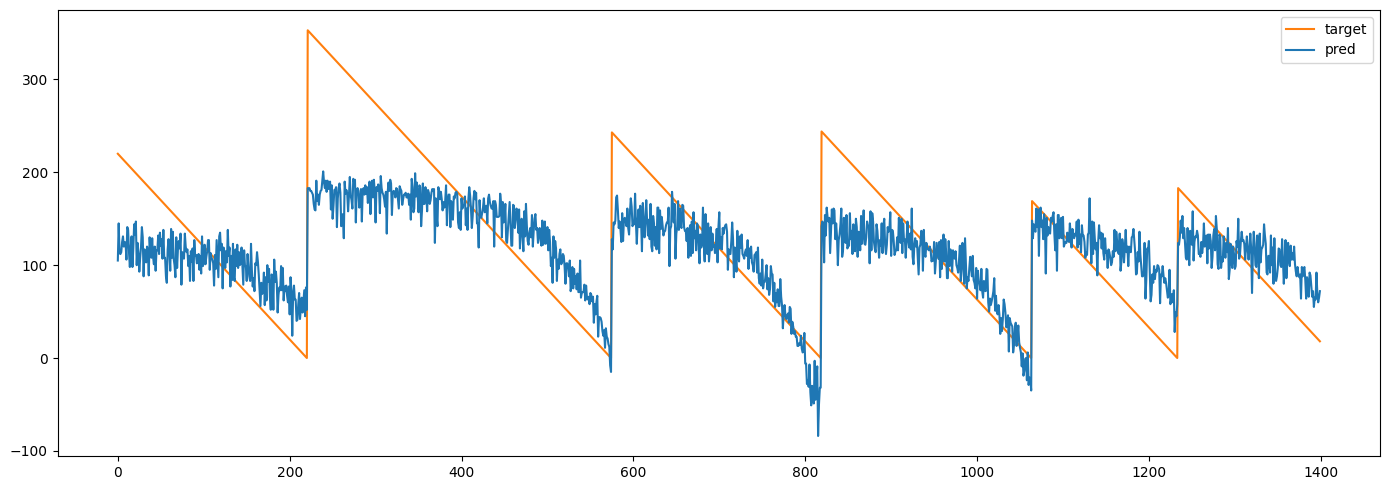

In [371]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [373]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0142
Standard Deviation of MSE: 0.0001


In [374]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [375]:
cst.save_results_to_excel("Task 3.10", mse_mean, mse_std, mse_seeds, excel_file_path)

In [377]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-10.xlsx')

In [378]:
pd.read_excel('./predictions/predictions-3-10.xlsx').head(10)

Seed_0  Seed_1  rul
0     105     110  220
1     145     149  219
2     113     128  218
3     112     139  217
4     114     132  216
5     125     115  215
6     131     134  214
7     120     157  213
8     125     157  212
9     124     124  211

##### 3.11 50% unsupervised, 75% supervised

In [379]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [380]:
ratio_unsup = 0.50 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [381]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [382]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-11.log')

Epoch 1/5
915/915 [==============================] - 3s 3ms/step - loss: 0.0274 - mse: 0.0215 - cst: 0.0059 - val_loss: 0.0185 - val_mse: 0.0170 - val_cst: 0.0015
Epoch 2/5
915/915 [==============================] - 3s 4ms/step - loss: 0.0164 - mse: 0.0143 - cst: 0.0020 - val_loss: 0.0179 - val_mse: 0.0160 - val_cst: 0.0020
Epoch 3/5
915/915 [==============================] - 4s 4ms/step - loss: 0.0155 - mse: 0.0132 - cst: 0.0023 - val_loss: 0.0155 - val_mse: 0.0142 - val_cst: 0.0013
Epoch 4/5
915/915 [==============================] - 4s 4ms/step - loss: 0.0148 - mse: 0.0126 - cst: 0.0022 - val_loss: 0.0149 - val_mse: 0.0133 - val_cst: 0.0016
Epoch 5/5
86/86 [==============================] - 0s 439us/step
Epoch 1/5
915/915 [==============================] - 4s 4ms/step - loss: 0.0225 - mse: 0.0190 - cst: 0.0035 - val_loss: 0.0237 - val_mse: 0.0206 - val_cst: 0.0032
Epoch 2/5
915/915 [==============================] - 4s 4ms/step - loss: 0.0182 - mse: 0.0159 - cst: 0.0023 - val_loss: 

Train history visualization for the first seed

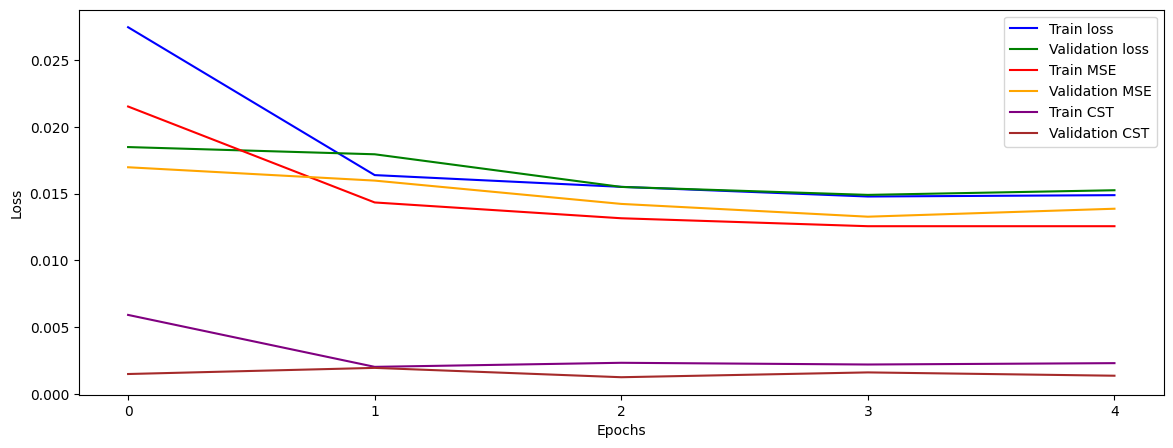

In [383]:
history = pd.read_csv('history/training-3-11.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

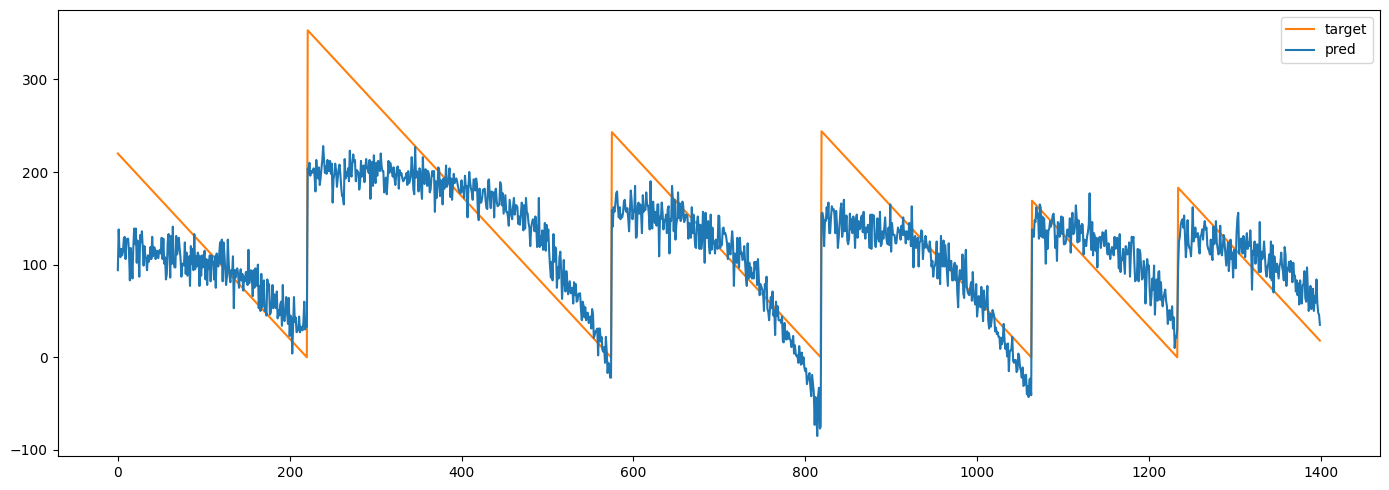

In [384]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [385]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0121
Standard Deviation of MSE: 0.0002


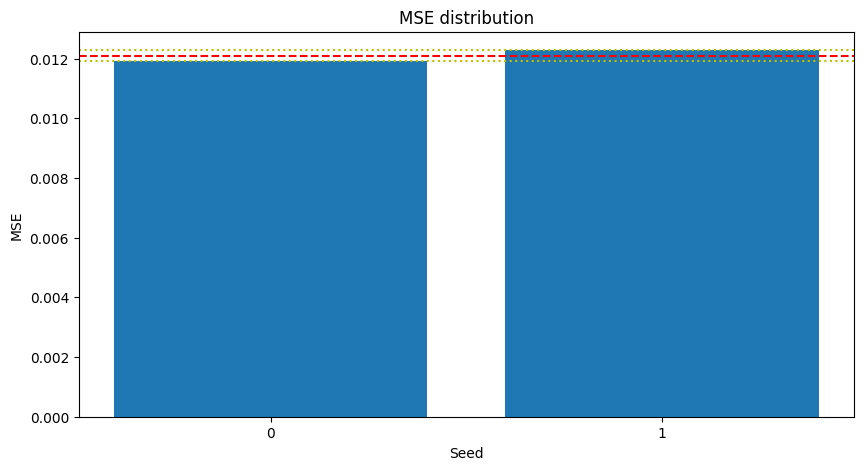

In [386]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [387]:
cst.save_results_to_excel("Task 3.11", mse_mean, mse_std, mse_seeds, excel_file_path)

In [389]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-11.xlsx')

In [390]:
pd.read_excel('./predictions/predictions-3-11.xlsx').head(10)

Seed_0  Seed_1  rul
0      94     143  220
1     138     138  219
2     112     162  218
3     108     133  217
4     117     165  216
5     110      92  215
6     114     135  214
7     128     148  213
8     130     151  212
9     106     121  211

##### 3.12 50% unsupervised, 50% supervised

In [392]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [393]:
ratio_unsup = 0.50
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 13912 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [394]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [395]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-12.log')

Epoch 1/5
682/682 [==============================] - 3s 4ms/step - loss: 0.0252 - mse: 0.0180 - cst: 0.0071 - val_loss: 0.0208 - val_mse: 0.0192 - val_cst: 0.0015
Epoch 2/5
682/682 [==============================] - 2s 4ms/step - loss: 0.0157 - mse: 0.0138 - cst: 0.0019 - val_loss: 0.0203 - val_mse: 0.0171 - val_cst: 0.0032
Epoch 3/5
682/682 [==============================] - 3s 4ms/step - loss: 0.0144 - mse: 0.0124 - cst: 0.0020 - val_loss: 0.0161 - val_mse: 0.0144 - val_cst: 0.0017
Epoch 4/5
682/682 [==============================] - 3s 4ms/step - loss: 0.0137 - mse: 0.0116 - cst: 0.0020 - val_loss: 0.0148 - val_mse: 0.0135 - val_cst: 0.0014
Epoch 5/5
86/86 [==============================] - 0s 417us/step
Epoch 1/5
682/682 [==============================] - 3s 4ms/step - loss: 0.0224 - mse: 0.0183 - cst: 0.0040 - val_loss: 0.0214 - val_mse: 0.0199 - val_cst: 0.0015
Epoch 2/5
682/682 [==============================] - 3s 4ms/step - loss: 0.0172 - mse: 0.0151 - cst: 0.0021 - val_loss: 

Train history visualization for the first seed

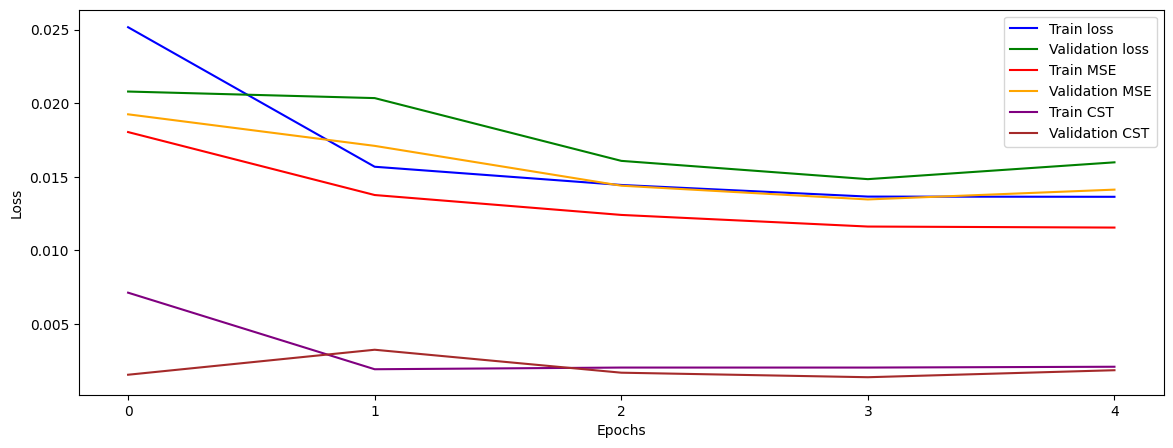

In [396]:
history = pd.read_csv('history/training-3-12.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

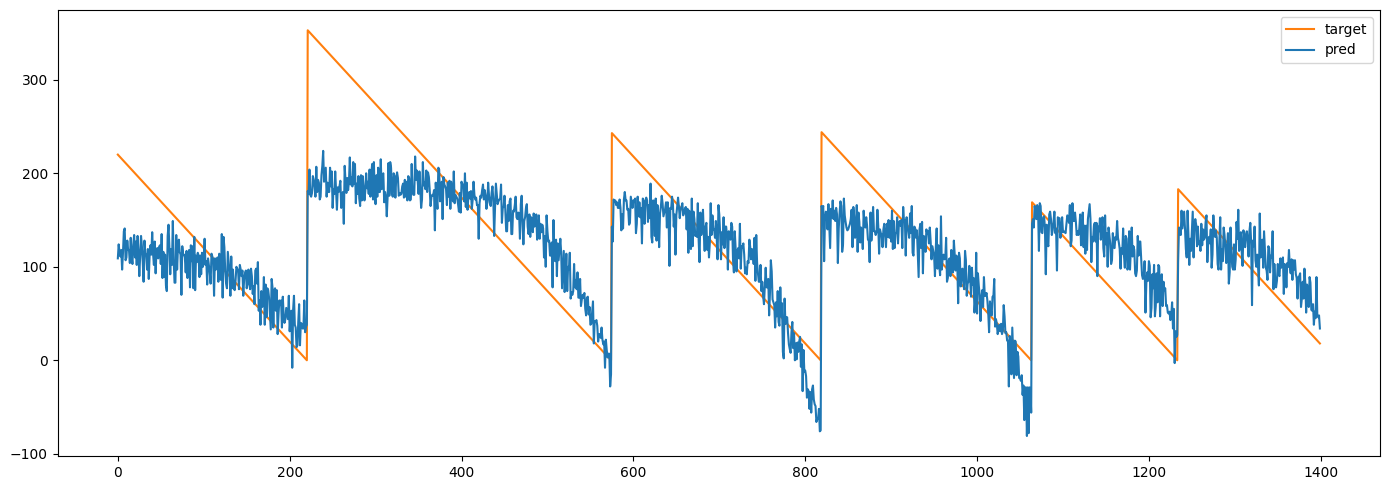

In [397]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [398]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0137
Standard Deviation of MSE: 0.0016


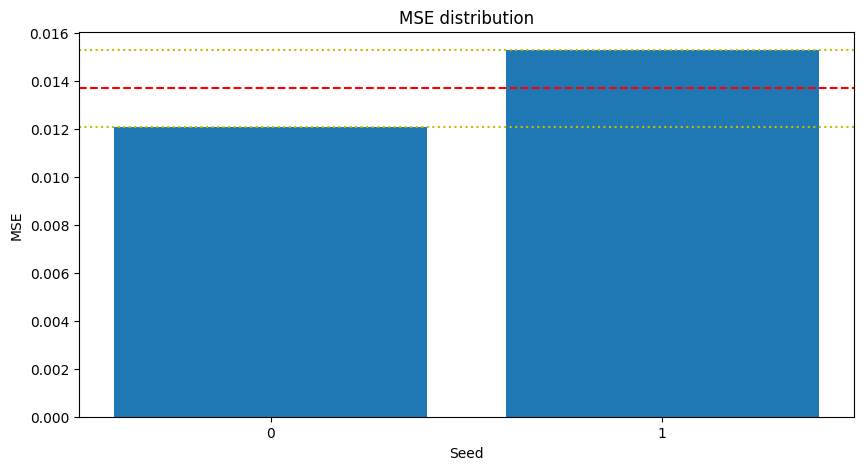

In [399]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [400]:
cst.save_results_to_excel("Task 3.12", mse_mean, mse_std, mse_seeds, excel_file_path)

In [402]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-12.xlsx')

In [403]:
pd.read_excel('./predictions/predictions-3-12.xlsx').head(10)

Seed_0  Seed_1  rul
0     109      80  220
1     124     125  219
2     115      99  218
3     111      88  217
4     118     103  216
5      97      86  215
6     115     106  214
7     138     115  213
8     141     118  212
9     107      92  211

##### 3.13 50% unsupervised, 25% supervised

In [404]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [405]:
ratio_unsup = 0.50 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 7406 (unsupervised), 15864 (validation), 2748 (test)


In [406]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [407]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-13.log')

Epoch 1/5
449/449 [==============================] - 2s 4ms/step - loss: 0.0265 - mse: 0.0153 - cst: 0.0112 - val_loss: 0.0250 - val_mse: 0.0232 - val_cst: 0.0018
Epoch 2/5
449/449 [==============================] - 2s 4ms/step - loss: 0.0112 - mse: 0.0099 - cst: 0.0013 - val_loss: 0.0203 - val_mse: 0.0188 - val_cst: 0.0015
Epoch 3/5
449/449 [==============================] - 2s 4ms/step - loss: 0.0103 - mse: 0.0087 - cst: 0.0016 - val_loss: 0.0194 - val_mse: 0.0172 - val_cst: 0.0022
Epoch 4/5
449/449 [==============================] - 3s 6ms/step - loss: 0.0096 - mse: 0.0080 - cst: 0.0017 - val_loss: 0.0163 - val_mse: 0.0150 - val_cst: 0.0013
Epoch 5/5
86/86 [==============================] - 0s 412us/step
Epoch 1/5
449/449 [==============================] - 2s 4ms/step - loss: 0.0180 - mse: 0.0131 - cst: 0.0048 - val_loss: 0.0225 - val_mse: 0.0212 - val_cst: 0.0013
Epoch 2/5
449/449 [==============================] - 2s 5ms/step - loss: 0.0125 - mse: 0.0107 - cst: 0.0017 - val_loss: 

Train history visualization for the first seed

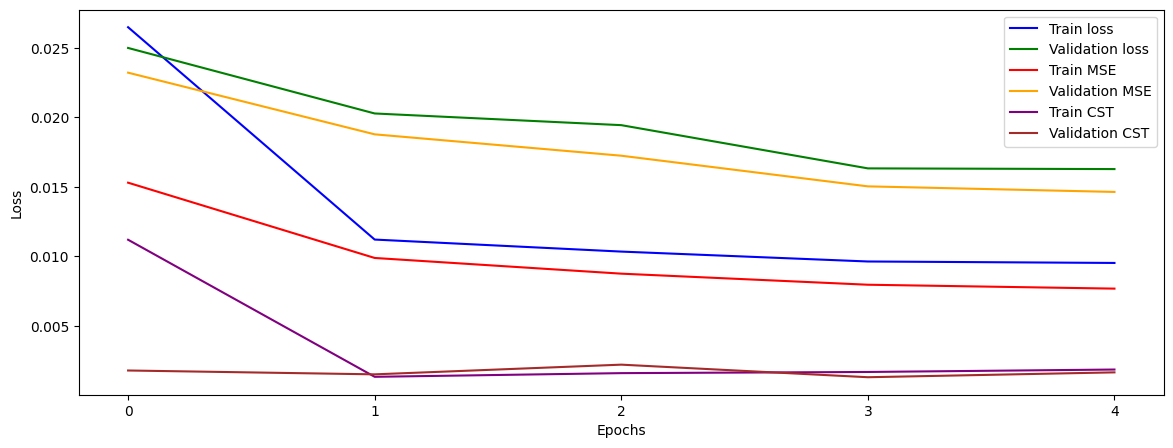

In [408]:
history = pd.read_csv('history/training-3-13.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

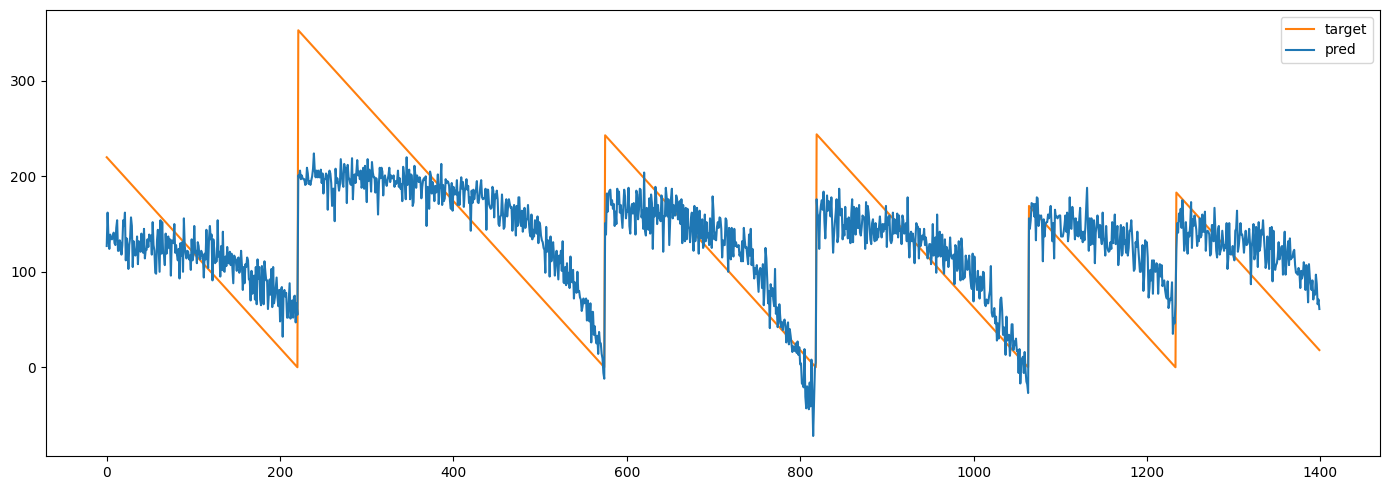

In [409]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [410]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0136
Standard Deviation of MSE: 0.0009


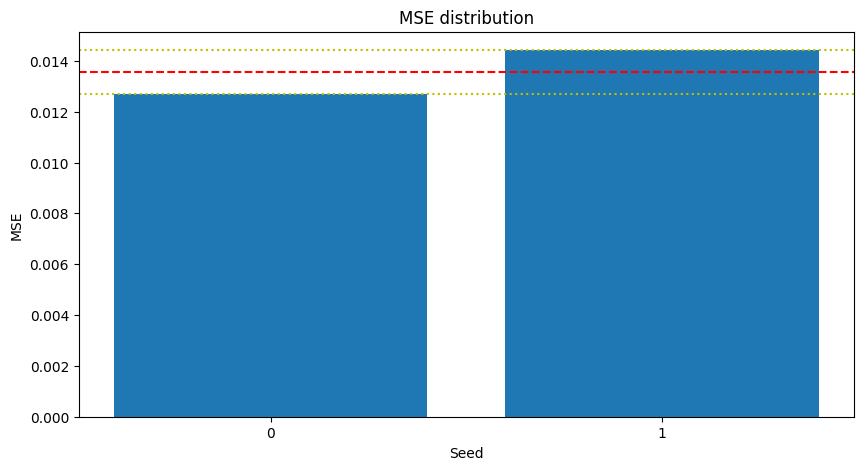

In [411]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [412]:
cst.save_results_to_excel("Task 3.13", mse_mean, mse_std, mse_seeds, excel_file_path)

In [415]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-13.xlsx')

In [416]:
pd.read_excel('./predictions/predictions-3-13.xlsx').head(10)

Seed_0  Seed_1  rul
0     127     125  220
1     162     166  219
2     136     145  218
3     124     157  217
4     139     150  216
5     136     127  215
6     134     154  214
7     136     174  213
8     141     177  212
9     130     142  211

##### 3.14 25% unsupervised, 75% supervised

In [417]:
tr, ts, trs, tru,vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [418]:
ratio_unsup = 0.25 
ratio_sup = 0.75
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 20868 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [419]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [420]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-14.log')

Epoch 1/5
805/805 [==============================] - 3s 4ms/step - loss: 0.0310 - mse: 0.0249 - cst: 0.0061 - val_loss: 0.0239 - val_mse: 0.0216 - val_cst: 0.0023
Epoch 2/5
805/805 [==============================] - 3s 4ms/step - loss: 0.0194 - mse: 0.0172 - cst: 0.0022 - val_loss: 0.0210 - val_mse: 0.0186 - val_cst: 0.0024
Epoch 3/5
805/805 [==============================] - 3s 4ms/step - loss: 0.0178 - mse: 0.0155 - cst: 0.0023 - val_loss: 0.0179 - val_mse: 0.0158 - val_cst: 0.0021
Epoch 4/5
805/805 [==============================] - 3s 4ms/step - loss: 0.0168 - mse: 0.0147 - cst: 0.0021 - val_loss: 0.0151 - val_mse: 0.0134 - val_cst: 0.0017
Epoch 5/5
86/86 [==============================] - 0s 451us/step
Epoch 1/5
805/805 [==============================] - 3s 3ms/step - loss: 0.0265 - mse: 0.0223 - cst: 0.0042 - val_loss: 0.0198 - val_mse: 0.0183 - val_cst: 0.0015
Epoch 2/5
805/805 [==============================] - 3s 4ms/step - loss: 0.0210 - mse: 0.0186 - cst: 0.0025 - val_loss: 

Train history visualization for the first seed

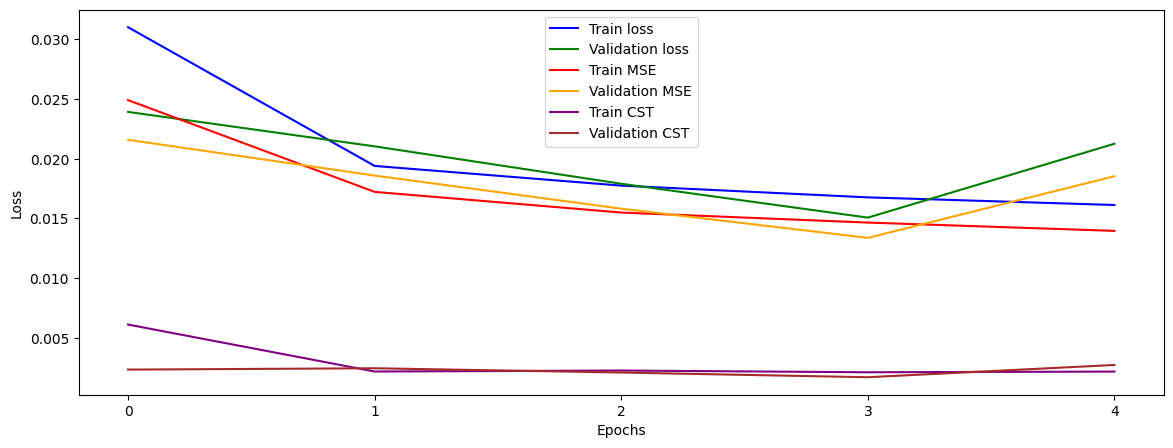

In [421]:
history = pd.read_csv('history/training-3-14.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

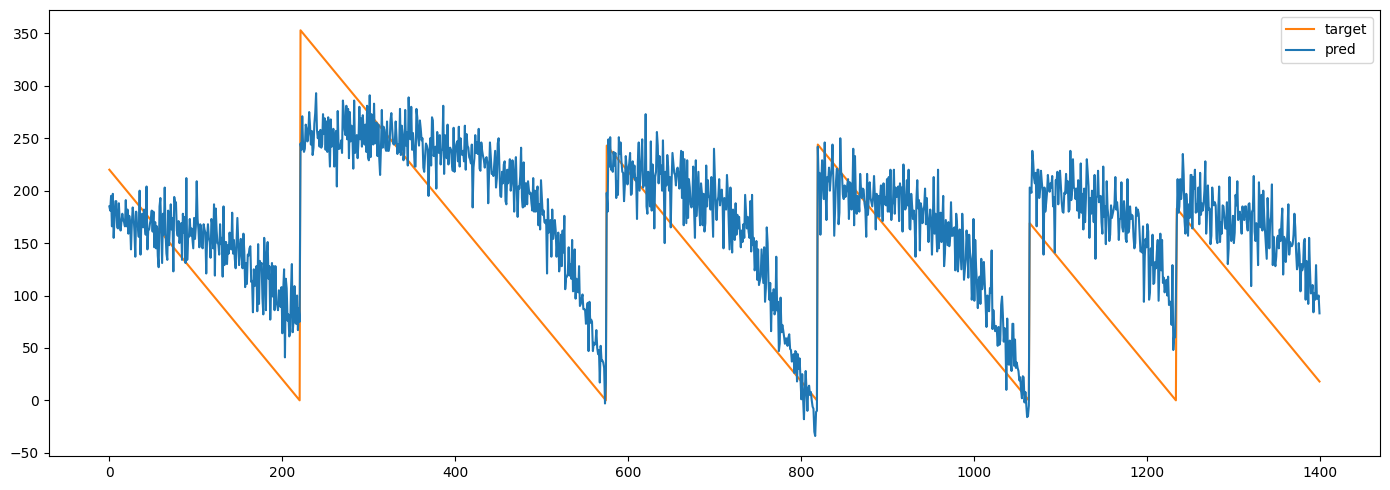

In [422]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [423]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0150
Standard Deviation of MSE: 0.0027


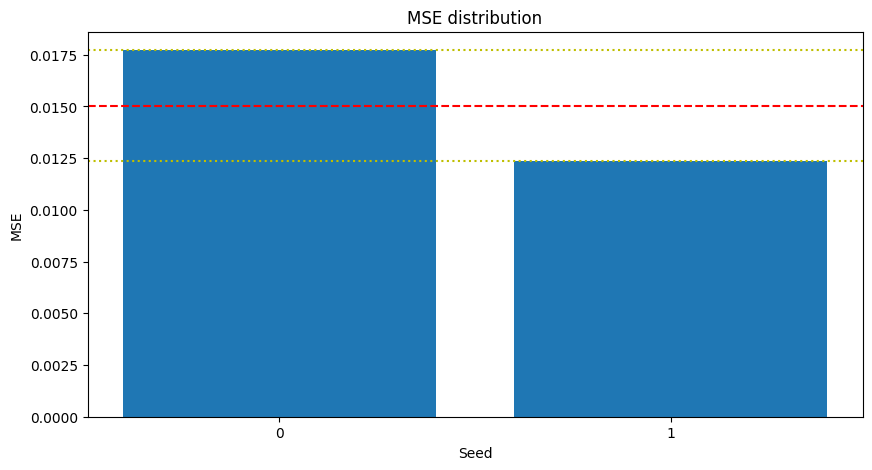

In [424]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [425]:
cst.save_results_to_excel("Task 3.14", mse_mean, mse_std, mse_seeds, excel_file_path)

In [428]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-14.xlsx')

In [429]:
pd.read_excel('./predictions/predictions-3-14.xlsx').head(10)

Seed_0  Seed_1  rul
0     185     154  220
1     181     169  219
2     195     175  218
3     166     128  217
4     197     178  216
5     155     121  215
6     174     165  214
7     190     156  213
8     190     156  212
9     165     148  211

##### 3.15 25% unsupervised, 50% supervised

In [430]:
tr, ts, trs, tru, vs= cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [431]:
ratio_unsup = 0.25 
ratio_sup = 0.50
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 13912 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [432]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [433]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-15.log')

Epoch 1/5
572/572 [==============================] - 2s 4ms/step - loss: 0.0331 - mse: 0.0245 - cst: 0.0087 - val_loss: 0.0262 - val_mse: 0.0216 - val_cst: 0.0046
Epoch 2/5
572/572 [==============================] - 2s 4ms/step - loss: 0.0188 - mse: 0.0169 - cst: 0.0019 - val_loss: 0.0202 - val_mse: 0.0173 - val_cst: 0.0029
Epoch 3/5
572/572 [==============================] - 2s 4ms/step - loss: 0.0173 - mse: 0.0151 - cst: 0.0021 - val_loss: 0.0160 - val_mse: 0.0145 - val_cst: 0.0016
Epoch 4/5
572/572 [==============================] - 3s 5ms/step - loss: 0.0163 - mse: 0.0142 - cst: 0.0021 - val_loss: 0.0156 - val_mse: 0.0139 - val_cst: 0.0018
Epoch 5/5
86/86 [==============================] - 0s 429us/step
Epoch 1/5
572/572 [==============================] - 3s 4ms/step - loss: 0.0264 - mse: 0.0216 - cst: 0.0048 - val_loss: 0.0224 - val_mse: 0.0201 - val_cst: 0.0024
Epoch 2/5
572/572 [==============================] - 2s 4ms/step - loss: 0.0204 - mse: 0.0182 - cst: 0.0022 - val_loss: 

Train history visualization for the first seed

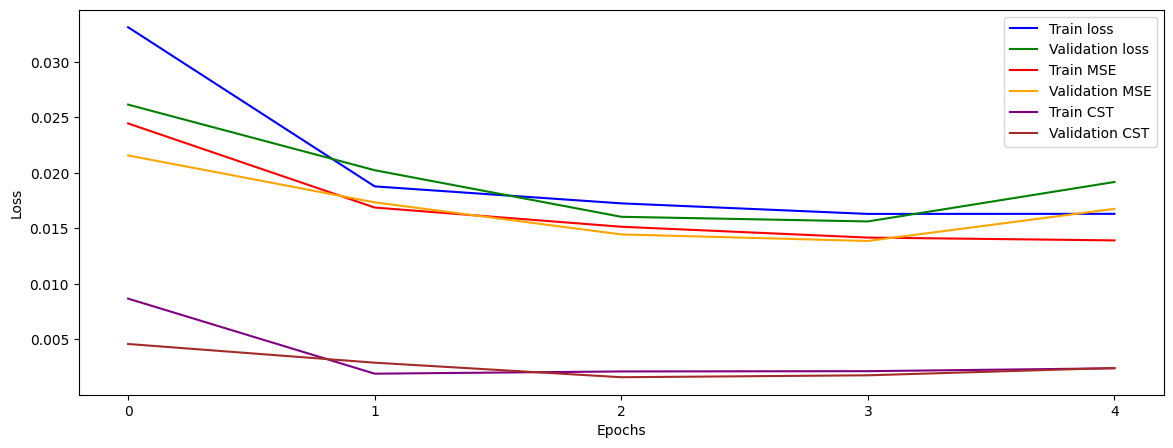

In [434]:
history = pd.read_csv('history/training-3-15.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

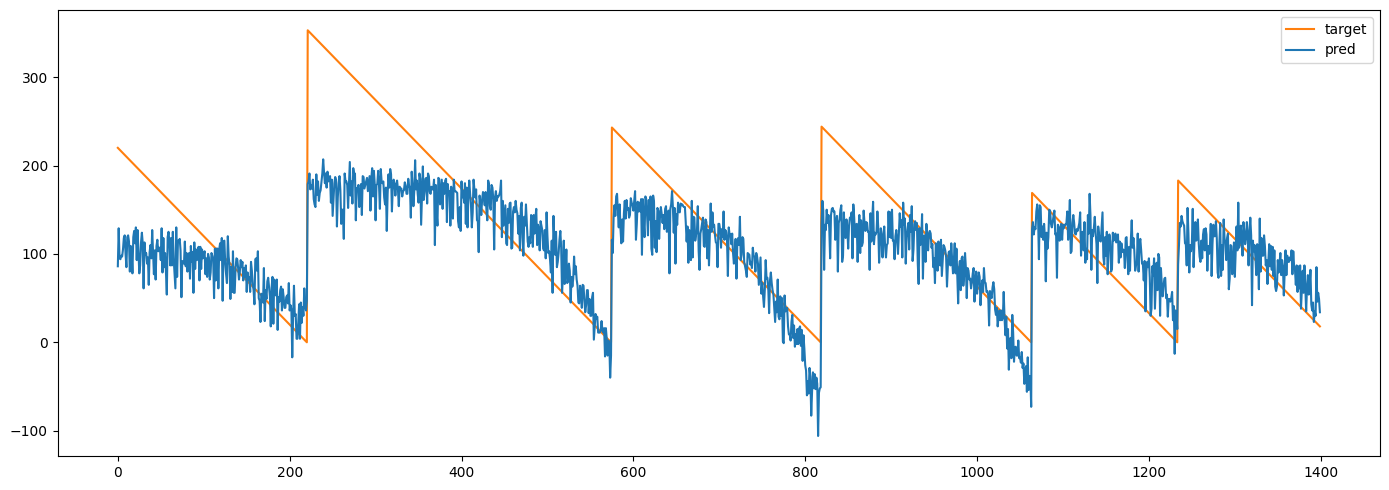

In [435]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [436]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0155
Standard Deviation of MSE: 0.0011


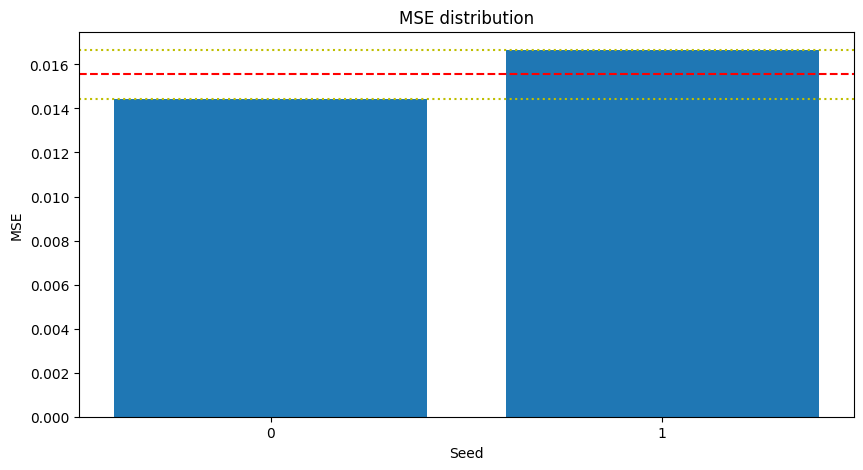

In [437]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [438]:
cst.save_results_to_excel("Task 3.15", mse_mean, mse_std, mse_seeds, excel_file_path)

In [440]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-15.xlsx')

In [441]:
pd.read_excel('./predictions/predictions-3-15.xlsx').head(10)

Seed_0  Seed_1  rul
0      86     157  220
1     129     194  219
2      95     176  218
3      94     161  217
4      98     181  216
5      97     153  215
6     105     168  214
7     118     184  213
8     121     186  212
9     100     154  211

##### 3.16 25% unsupervised, 25% supervised

In [442]:
tr, ts, trs, tru, vs = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 112 (supervised), 168 (unsupervised), 12 (validation), 63 (test)


In [443]:
ratio_unsup = 0.25 
ratio_sup = 0.25
tru = tru[:int(len(tru) * ratio_unsup)]
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. samples: 6956 (supervised), 3703 (unsupervised), 15864 (validation), 2748 (test)


In [444]:
trs_s, tru_s, vs_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)
trsu_s = pd.concat((trs_s, tru_st))

In [445]:
history, predictions = train_model(train_data=trsu_s, val_data = vs_s, test_data=ts_s, columns=dt_in,
                                maxrul=trmaxrul, alpha=1, beta=1, logger_file = 'training-3-16.log')

Epoch 1/5
339/339 [==============================] - 2s 5ms/step - loss: 0.0341 - mse: 0.0211 - cst: 0.0130 - val_loss: 0.0266 - val_mse: 0.0244 - val_cst: 0.0022
Epoch 2/5
339/339 [==============================] - 2s 5ms/step - loss: 0.0156 - mse: 0.0138 - cst: 0.0017 - val_loss: 0.0216 - val_mse: 0.0197 - val_cst: 0.0020
Epoch 3/5
339/339 [==============================] - 2s 5ms/step - loss: 0.0138 - mse: 0.0120 - cst: 0.0018 - val_loss: 0.0193 - val_mse: 0.0174 - val_cst: 0.0019
Epoch 4/5
339/339 [==============================] - 2s 6ms/step - loss: 0.0128 - mse: 0.0109 - cst: 0.0019 - val_loss: 0.0212 - val_mse: 0.0173 - val_cst: 0.0039
Epoch 5/5
86/86 [==============================] - 0s 425us/step
Epoch 1/5
339/339 [==============================] - 2s 6ms/step - loss: 0.0242 - mse: 0.0179 - cst: 0.0063 - val_loss: 0.0334 - val_mse: 0.0304 - val_cst: 0.0030
Epoch 2/5
339/339 [==============================] - 2s 5ms/step - loss: 0.0159 - mse: 0.0140 - cst: 0.0019 - val_loss: 

Train history visualization for the first seed

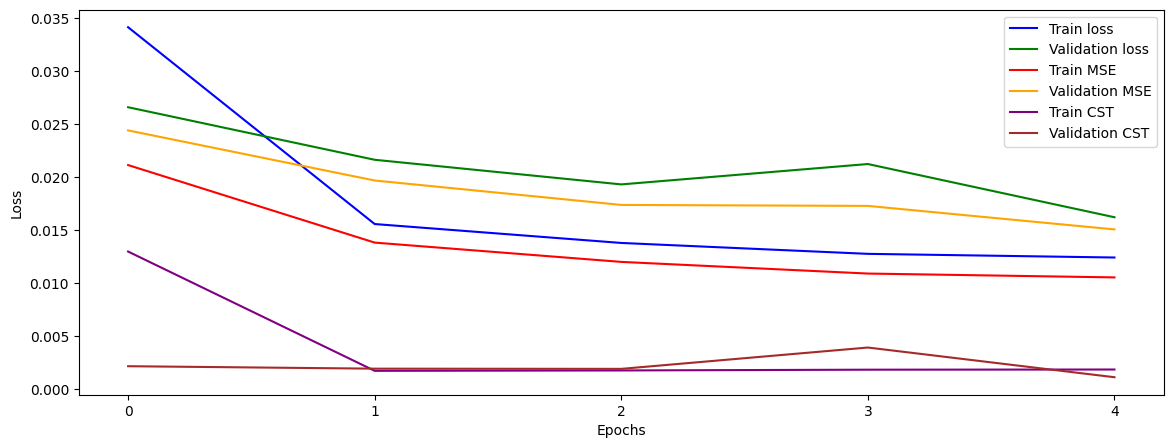

In [446]:
history = pd.read_csv('history/training-3-16.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

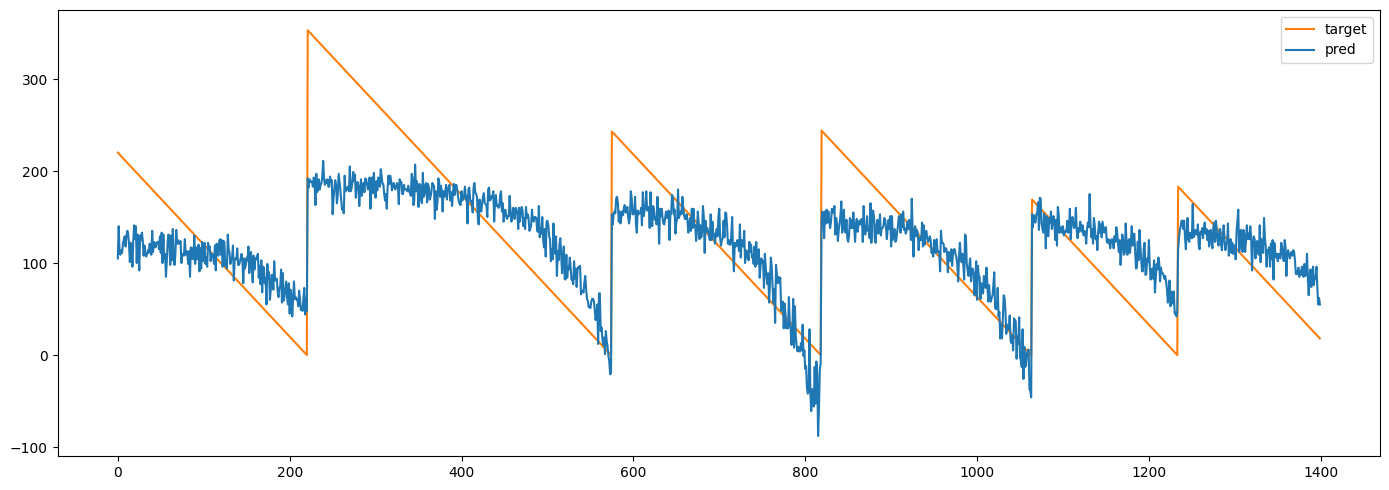

In [447]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [448]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0154
Standard Deviation of MSE: 0.0024


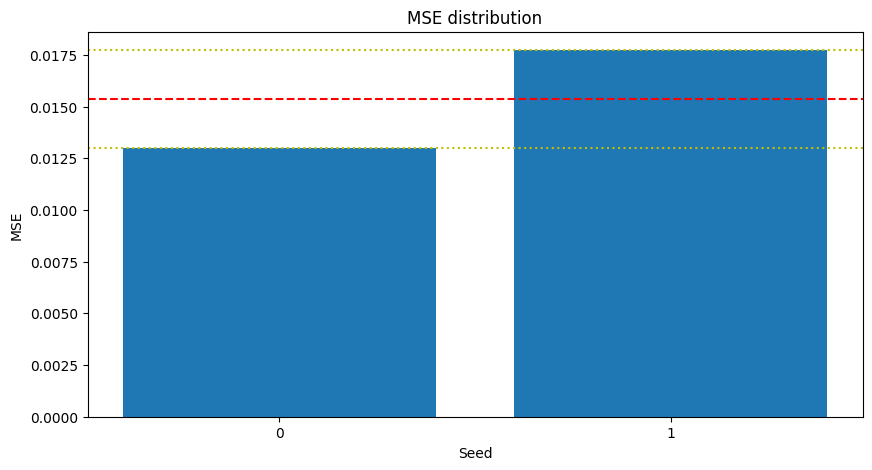

In [449]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

Save results and predictions on excel files and show them

In [450]:
cst.save_results_to_excel("Task 3.16", mse_mean, mse_std, mse_seeds, excel_file_path)

In [452]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-3-16.xlsx')

In [453]:
pd.read_excel('./predictions/predictions-3-16.xlsx').head(10)

Seed_0  Seed_1  rul
0     105     170  220
1     140     172  219
2     112     189  218
3     109     159  217
4     114     195  216
5     111     133  215
6     122     177  214
7     125     177  213
8     129     179  212
9     118     166  211

#### Results on Task 3

In [464]:
results_task3 = pd.read_excel('results.xlsx')

results_task3_1= results_task3[results_task3['Task'] == 'Task 3.1']
results_task3_2 = results_task3[results_task3['Task'] == 'Task 3.2']
results_task3_3 = results_task3[results_task3['Task'] == 'Task 3.3']
results_task3_4 = results_task3[results_task3['Task'] == 'Task 3.4']
results_task3_5 = results_task3[results_task3['Task'] == 'Task 3.5']
results_task3_6 = results_task3[results_task3['Task'] == 'Task 3.6']
results_task3_7 = results_task3[results_task3['Task'] == 'Task 3.7']
results_task3_8 = results_task3[results_task3['Task'] == 'Task 3.8']
results_task3_9 = results_task3[results_task3['Task'] == 'Task 3.9']
results_task3_10 = results_task3[results_task3['Task'] == 'Task 3.10']
results_task3_11 = results_task3[results_task3['Task'] == 'Task 3.11']
results_task3_12 = results_task3[results_task3['Task'] == 'Task 3.12']
results_task3_13 = results_task3[results_task3['Task'] == 'Task 3.13']
results_task3_14 = results_task3[results_task3['Task'] == 'Task 3.14']
results_task3_15 = results_task3[results_task3['Task'] == 'Task 3.15']
results_task3_16 = results_task3[results_task3['Task'] == 'Task 3.16']

res_task3 = pd.concat([results_task3_1, results_task3_2, results_task3_3, results_task3_4, results_task3_5, results_task3_6, results_task3_7, results_task3_8, results_task3_9, results_task3_10, results_task3_11, results_task3_12, results_task3_13, results_task3_14, results_task3_15, results_task3_16]).drop(columns=drop_columns)

print(tabulate(res_task3, headers='keys', showindex=False,  tablefmt='psql'))



+-----------+-----------+-------------+
| Task      |      Mean |         Std |
|-----------+-----------+-------------|
| Task 3.1  | 0.0153695 | 0.00236908  |
| Task 3.2  | 0.0119713 | 0.000409097 |
| Task 3.3  | 0.0136126 | 0.000180153 |
| Task 3.4  | 0.022932  | 0.00148022  |
| Task 3.5  | 0.0146569 | 0.000394971 |
| Task 3.6  | 0.012444  | 0.00090176  |
| Task 3.7  | 0.0112475 | 0.000127277 |
| Task 3.8  | 0.011417  | 0.000486175 |
| Task 3.9  | 0.0123173 | 0.000346833 |
| Task 3.10 | 0.0141625 | 6.87589e-05 |
| Task 3.11 | 0.0120977 | 0.000188329 |
| Task 3.12 | 0.0136844 | 0.00159533  |
| Task 3.13 | 0.0135613 | 0.000862583 |
| Task 3.14 | 0.0150377 | 0.0026858   |
| Task 3.15 | 0.0155426 | 0.00110847  |
| Task 3.16 | 0.0153695 | 0.00236908  |
+-----------+-----------+-------------+


Comments on the results + choice of the best model needed for task 4

### **Task 4**: Domain Knowledge injection by adding a new regularizer. We want to enforce the RUL being strictly positive

We think that adding a regularizer to enforce the RUL to be strictly positive will have a positive influence on model's performances with only unsupervised data. Indeed inferring **domain knowledge** will enhance the prediction qualiy of the regressor.
As a matter of fact we expect that the following model will achieve better results in comparison with the previous one (that considers only unsupervised data).

Tuning the hyperparameter *gamma* should have a great impact on the results obtained.

In [36]:
#usando unsupervised 100% e gamma = 0.1 -> Media della MSE: 0.0324, Deviazione standard della MSE: 0.0072
#TODO: tuning di paramentro gamma 

In [473]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')

Num. machines: 149 (unsupervised), 37 (validation), 63 (test)


In [475]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [477]:
history, predictions = train_task4(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=0.0, beta=1.0, gamma=1.0, logger_file = 'training-4.log')
    

Epoch 1/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0039 - mse: 0.0330 - cst: 0.0039 - positivity_regularizer: 1.7118e-05 - val_loss: 4.6883e-04 - val_mse: 0.0262 - val_cst: 4.6883e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 5.2657e-04 - mse: 0.0335 - cst: 5.2657e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 4.6920e-04 - val_mse: 0.0302 - val_cst: 4.6920e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 3/5
1232/1232 [==============================] - 4s 3ms/step - loss: 5.3166e-04 - mse: 0.0371 - cst: 5.3166e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 6.4563e-04 - val_mse: 0.0330 - val_cst: 6.4563e-04 - val_positivity_regularizer: 0.0000e+00
Epoch 4/5
1232/1232 [==============================] - 4s 3ms/step - loss: 5.3109e-04 - mse: 0.0404 - cst: 5.3109e-04 - positivity_regularizer: 0.0000e+00 - val_loss: 4.4027e-04 - val_mse: 0.0362 - val_cst: 4.4027e-04 - val_positiv

Train history visualization for the first seed

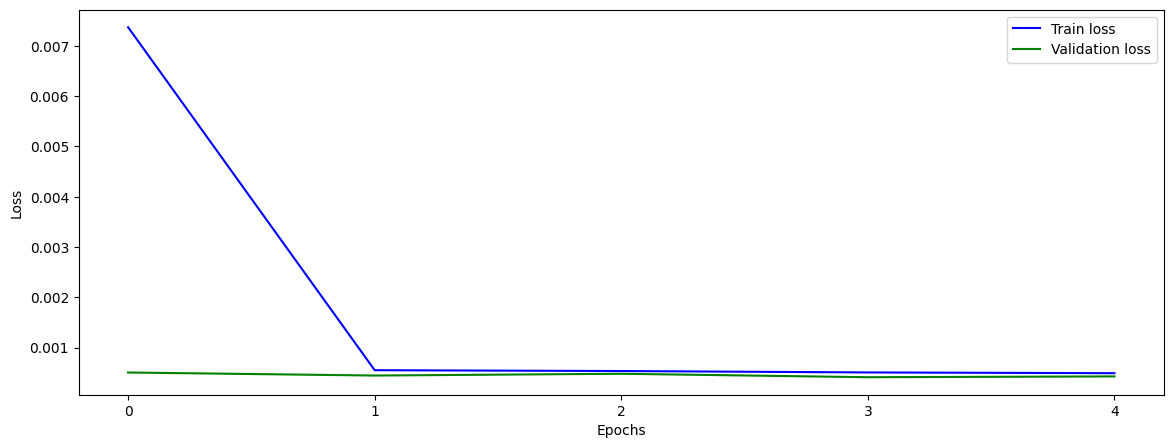

In [478]:
history = pd.read_csv('history/training-4.log')
cst.plot_losses(history, epochs)


Comment: bisogna vedere su più epoche

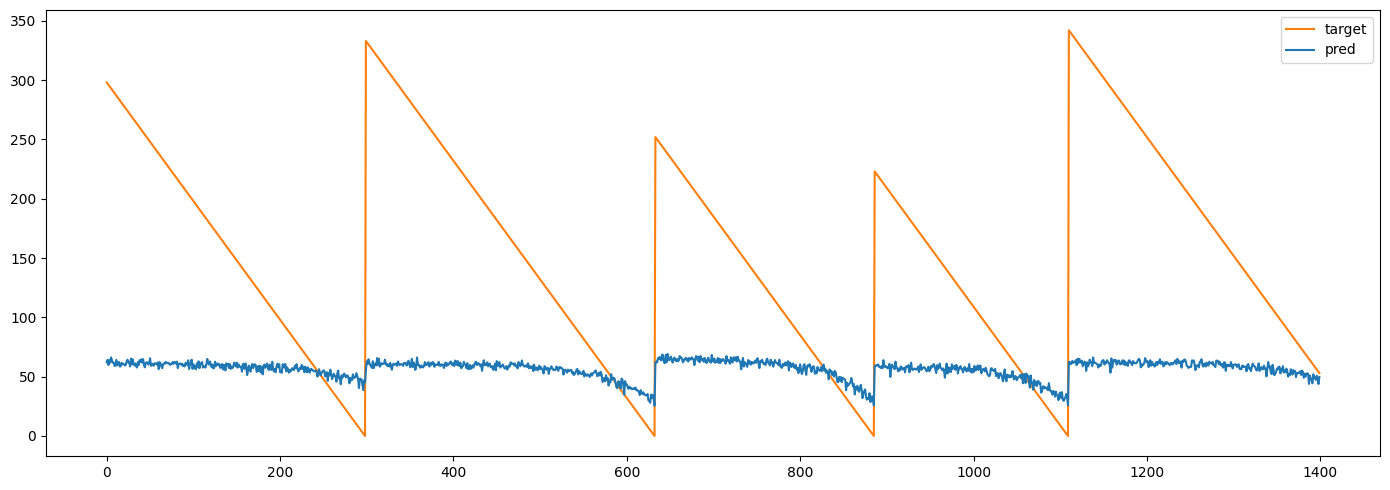

In [479]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [480]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0476
Standard Deviation of MSE: 0.0006


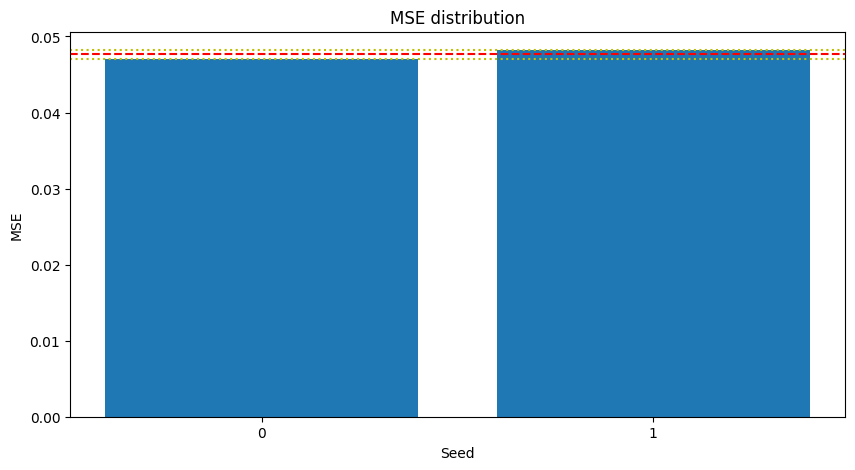

In [485]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [486]:
cst.save_results_to_excel("Task 4", mse_mean, mse_std, mse_seeds, excel_file_path)

In [488]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-4.xlsx')

In [489]:
pd.read_excel('./predictions/predictions-4.xlsx').head(10)

Seed_0     Seed_1  rul
0  62.138096  62.103752  298
1  64.193642  56.975315  297
2  59.852818  62.605160  296
3  63.866558  64.047729  295
4  61.783493  57.752487  294
5  66.297554  58.223503  293
6  63.760525  54.602703  292
7  61.908695  55.721554  291
8  61.833778  56.920689  290
9  59.049957  57.216698  289

#### Results on Task 4

In [506]:
results_task4 = pd.read_excel('results.xlsx')

results_task4= results_task4[results_task4['Task'] == 'Task 4'].drop(columns=drop_columns)

print(tabulate(results_task4, headers='keys', showindex= False, tablefmt='psql'))

+--------+-----------+------------+
| Task   |      Mean |        Std |
|--------+-----------+------------|
| Task 4 | 0.0476351 | 0.00058229 |
+--------+-----------+------------+


### **Task 5**: Lagrangian for dinamic weight of the loss function

In fact, the fairness constraint and accuracy are conflicting goals
Satisfying the constraint has in this case higher priority

Introducing a Lagrange multiplier can be considered as a weight that dynamically adjusts the importance of the regularization term, allowing the model to learn its optimal value during training.

In [492]:
tru, vs, ts = cst.split_machines(dt, 0, 0.75)
print(f'Num. samples: {len(tru)} (unsupervised), {len(vs)} (validation), {len(ts)} (test)')


Num. machines: 149 (unsupervised), 37 (validation), 63 (test)
Num. samples: 36746 (unsupervised), 8639 (validation), 15864 (test)


In [ ]:
tru_s, vs_s, ts_s, trmaxrul = cst.standardize(tru, vs, ts, dt_in)
tru_st = cst.remove_rul(tru_s)

In [493]:
history, predictions = train_task5(train_data=trs_s, val_data=vs_s, test_data=ts_s, columns=dt_in, 
                             maxrul=trmaxrul, alpha=1, beta=0, logger_file = 'training-5.log')

Epoch 1/5
1232/1232 [==============================] - 5s 4ms/step - loss: 0.0272 - mse: 0.0222 - cst: 0.0051 - val_loss: 0.0197 - val_mse: 0.0172 - val_cst: 0.0029
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0164 - mse: 0.0148 - cst: 0.0025 - val_loss: 0.0187 - val_mse: 0.0178 - val_cst: 0.0026
Epoch 3/5
1232/1232 [==============================] - 4s 4ms/step - loss: 0.0149 - mse: 0.0147 - cst: 0.0037 - val_loss: 0.0155 - val_mse: 0.0155 - val_cst: 0.0051
Epoch 4/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0146 - mse: 0.0146 - cst: 0.0037 - val_loss: 0.0160 - val_mse: 0.0160 - val_cst: 0.0051
Epoch 5/5
496/496 [==============================] - 0s 486us/step
Epoch 1/5
1232/1232 [==============================] - 5s 4ms/step - loss: 0.0250 - mse: 0.0217 - cst: 0.0035 - val_loss: 0.0183 - val_mse: 0.0168 - val_cst: 0.0021
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0182 - mse: 0.0173 - cst: 0.003

Train history visualization for the first seed

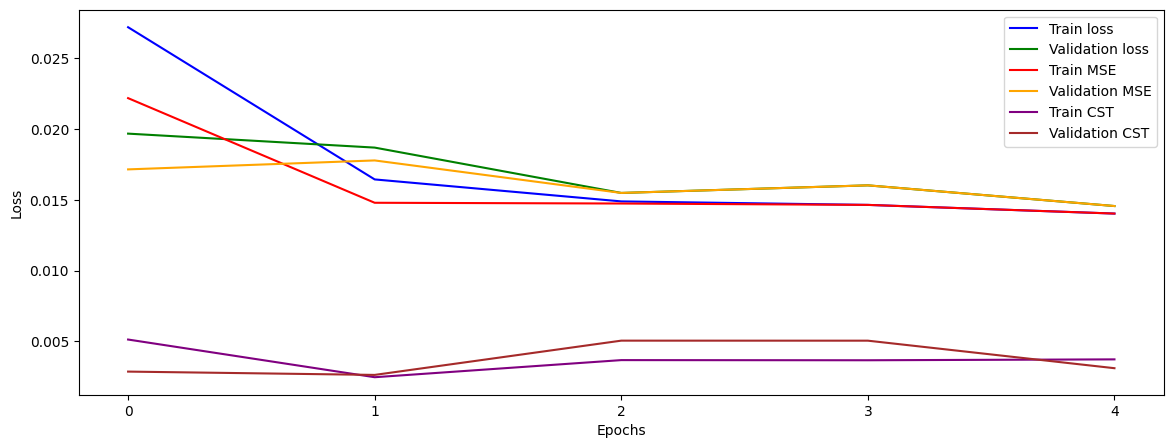

In [494]:
history = pd.read_csv('history/training-5.log')
cst.plot_losses_mixed(history, epochs)


Comment: bisogna vedere su più epoche

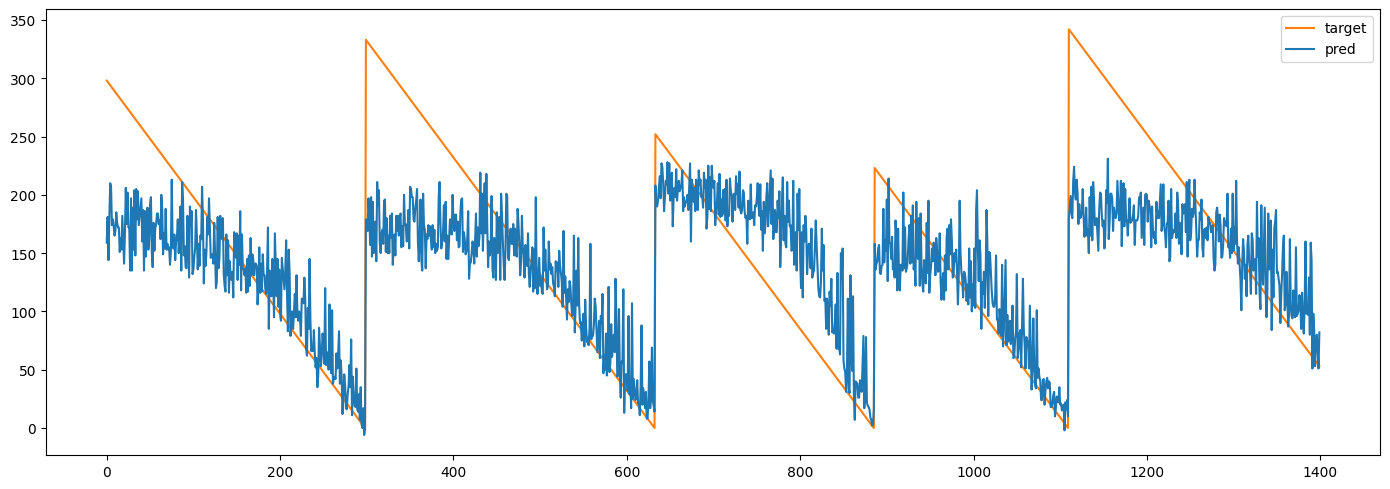

In [495]:
ts_pred = predictions[0]
cst.plot_rul(ts_pred[:stop], ts["rul"].iloc[:stop], figsize=figsize)

In [496]:
mse_seeds, mse_mean, mse_std = cst.evaluation(predictions/trmaxrul, ts_s)

Mean value for MSE: 0.0131
Standard Deviation of MSE: 0.0003


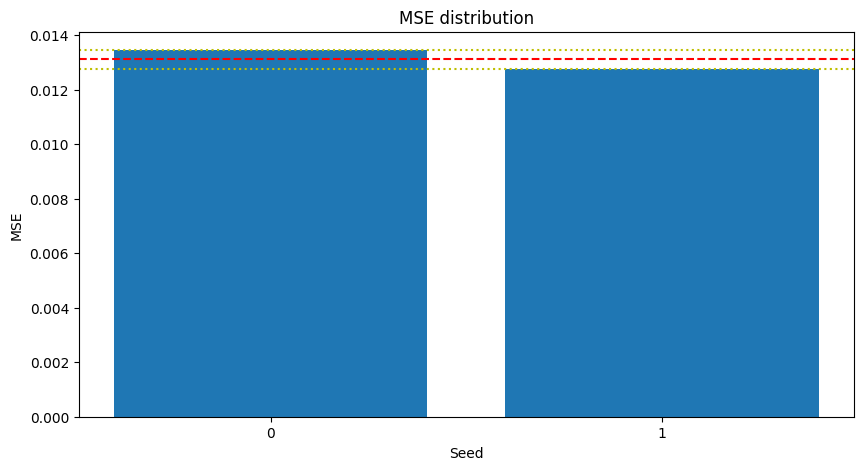

In [497]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

In [500]:
cst.save_results_to_excel("Task 5", mse_mean, mse_std, mse_seeds, excel_file_path)

In [502]:
cst.save_predictions_to_excel(predictions, ts["rul"], 'predictions-5.xlsx')

In [503]:
pd.read_excel('./predictions/predictions-5.xlsx').head(10)

Seed_0  Seed_1  rul
0     159     174  298
1     181     195  297
2     144     167  296
3     180     204  295
4     210     204  294
5     207     213  293
6     174     177  292
7     179     180  291
8     173     171  290
9     165     161  289

#### Results on Task 5

In [504]:
results_task5 = pd.read_excel('results.xlsx')

results_task5= results_task5[results_task5['Task'] == 'Task 5'].drop(columns=drop_columns)

print(tabulate(results_task5, headers='keys', showindex= False, tablefmt='psql'))

+--------+-----------+-------------+
| Task   |      Mean |         Std |
|--------+-----------+-------------|
| Task 5 | 0.0131068 | 0.000340185 |
+--------+-----------+-------------+


### **Final observations and comments**

In [505]:
results = pd.read_excel('results.xlsx')
results.drop(columns=drop_columns)

print(tabulate(results, headers='keys', showindex= False, tablefmt='psql'))


+------------+---------------+----------------+---------------+---------------+----------+
| Task       |          Mean |            Std |        Seed_0 |        Seed_1 |   Seed_2 |
|------------+---------------+----------------+---------------+---------------+----------|
| Task 1.1   |     0.0128889 |    0.000392717 |     0.0132816 |     0.0124962 |      nan |
| Task 1.2   |  4449.2       |  388.466       |  4060.73      |  4837.67      |      nan |
| Task 1.3   |  5079.34      |  571.356       |  5650.69      |  4507.98      |      nan |
| Task 2.1   | 18290.6       | 6147.15        | 12143.5       | 24437.8       |      nan |
| Task 2.2   | 18290.6       | 6147.15        | 12143.5       | 24437.8       |      nan |
| Task 3.1.1 |  4192.38      | 3017.9         |  7210.28      |  1174.48      |      nan |
| nan        |   nan         |  nan           |   nan         |   nan         |      nan |
| nan        |   nan         |  nan           |   nan         |   nan         |      nan |

Spiegare quale funziona meglio e perchè.. 
osservazioni finali